In [1]:
# This is a clean version of Part 1 and Part 2
# Part 1 is dense layer only random sample network
# Part 2 is LSTM with multiple input features

Before Transform
(5000, 10, 1) (5, 10, 1) (2508, 10, 1)
After Transform
(5000, 10) (5, 10) (2508, 10)
trainX,trainY
(5000, 10) (5000,)
Begin
inputshape
(10,)
Train on 4750 samples, validate on 250 samples
Epoch 1/15
4750/4750 [==============================] - 7s - loss: 7.0208e-04 - val_loss: 6.5436e-04

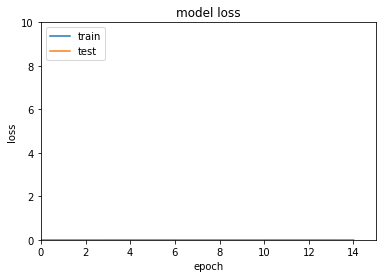

4986/5000 [============================>.] - ETA: 0s 

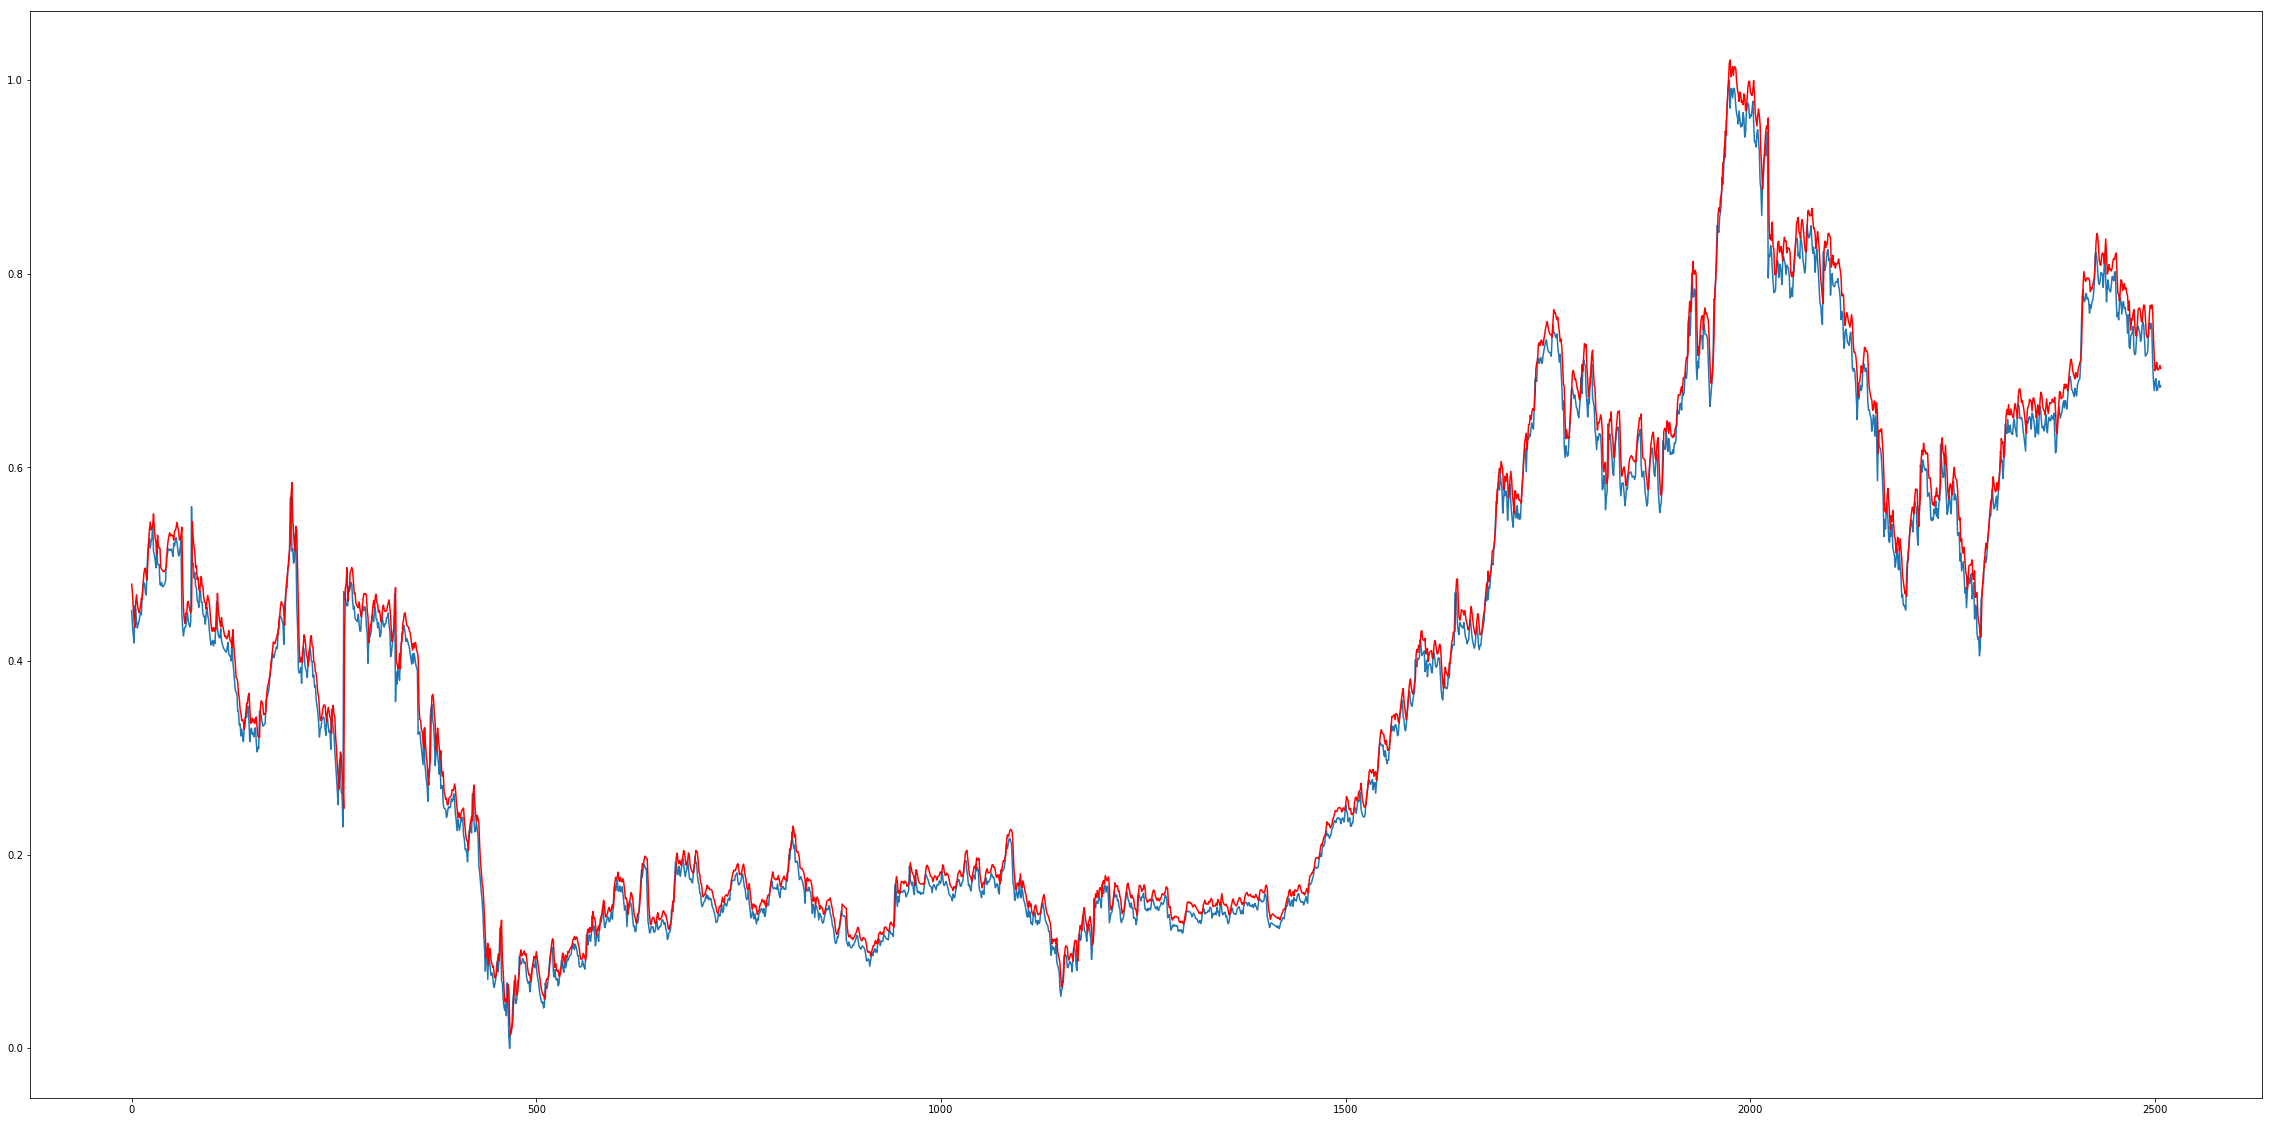

In [7]:
# Model 1, One Feature, Random window, Dense only but with multiple layers
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Convolution1D, Convolution2D
from keras.regularizers import l2, activity_l2
from keras.layers import Merge, LSTM, Dense 
from copy import deepcopy
np.random.seed(7) # fix random seed to ensure the results are reproducible

# reference from : http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# dataframe = pandas.read_csv('Yahoo+Nasdaq+SP500+DJ30-20100101-20161231.csv', usecols=['YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume'])
dataframe = pandas.read_csv('YHOO_2007-2016.csv', usecols=['YHOO-High'])
dataset = dataframe.values
# reverse the dataset by row, oldest date first
dataset = np.flip(dataset, 0) 
dataset.astype('float32')

# plot the dataset
# plt.title('Yahoo HighPrice - Date')
# plt.plot(dataset)
# plt.show()

# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split training and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:, :]
# convert an array of values into a dataset matrix
def create_random_dataset(dataset, look_back, iteration_time):
    dataX, dataY = [], []
    for i in range(iteration_time):
        start = randint(0, len(dataset)-look_back-1) # randint(a,b), a <= x <= b
        a = dataset[start:(start+look_back), :]
        dataX.append(a)
        dataY.append(dataset[start+look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_ordered_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = deepcopy(dataset[i:(i+look_back), :])
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape training and test set into X = t, Y = t + 1
look_back = 10
iteration_time = 5000
trainX, trainY = create_random_dataset(train, look_back, iteration_time)
testX, testY = create_random_dataset(test, look_back, 5)
orderedX, orderedY = create_ordered_dataset(dataset, look_back) # this is used for trend evaluation



#before Transform
print ("Before Transform")
print trainX.shape,testX.shape,orderedX.shape


# transform data into two dim input. Since it's already 2d, this part is useless. 
# If more features are used, we need this part to increase the dimension
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))
orderedX = np.reshape(orderedX, (orderedX.shape[0], orderedX.shape[1]))
# print(trainX[0:5])
# print(trainY.shape)

print ("After Transform")
print trainX.shape,testX.shape,orderedX.shape

print "trainX,trainY"
print trainX.shape,trainY.shape

# # create training network
# # Reference: Which optimizer to use
# # http://sebastianruder.com/optimizing-gradient-descent/index.html #rmsprop
batchSize = 2
epoch = 15
print("Begin")
print "inputshape"
print (look_back,)
model = Sequential()
# model.add(Dense(25, input_shape=(look_back,)))
model.add(Dense(25, input_dim=look_back))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse') # can try optimizer = 'adam'

history = model.fit(trainX, trainY, validation_split=0.05, batch_size=batchSize, nb_epoch=epoch, initial_epoch=0, verbose = 1)
print("-------Finish-------")

# Evaluation on MSE
    # With current parameter
    # MSE on trainX: 0.429521106769, MSE on testX: 0.610605459544
    # Graph of training and test mse, here training and test data are all in trainX
plt.axis((0, epoch, 0, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    # MSE on trainX and testX   
training_loss = model.evaluate(trainX, trainY, batch_size=batchSize, verbose = 1)
print("\nMSE on trainX: {}".format(training_loss))
test_loss = model.evaluate(testX, testY, batch_size=batchSize, verbose = 1)
print("\nMSE on testX: {}".format(test_loss))
cv = (np.sqrt(test_loss) / np.mean(testY)) * 100
print("Coefficient of Variation: ", cv, "%")

# Evaluation on Trend
orderedYHat_DENSE = model.predict(orderedX, batch_size = batchSize, verbose = 0);
# The YHat has one day delay compared with Y, that's the reason for previous bad performance
def evaluateY(Y, YHat):
    total = len(Y)
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    print("Trend prediction performance: {}%".format(count * 100.0 / total))
print('Overall:')
evaluateY(orderedY, orderedYHat_DENSE)    
print('Test Set Only:')
evaluateY(orderedY[train_size:], orderedYHat_DENSE[train_size:])  

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_DENSE[:], c = 'r')
plt.show()

# predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# denormalization
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform(trainY)
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform(testY)

(2498, 2498, 2498)
2518


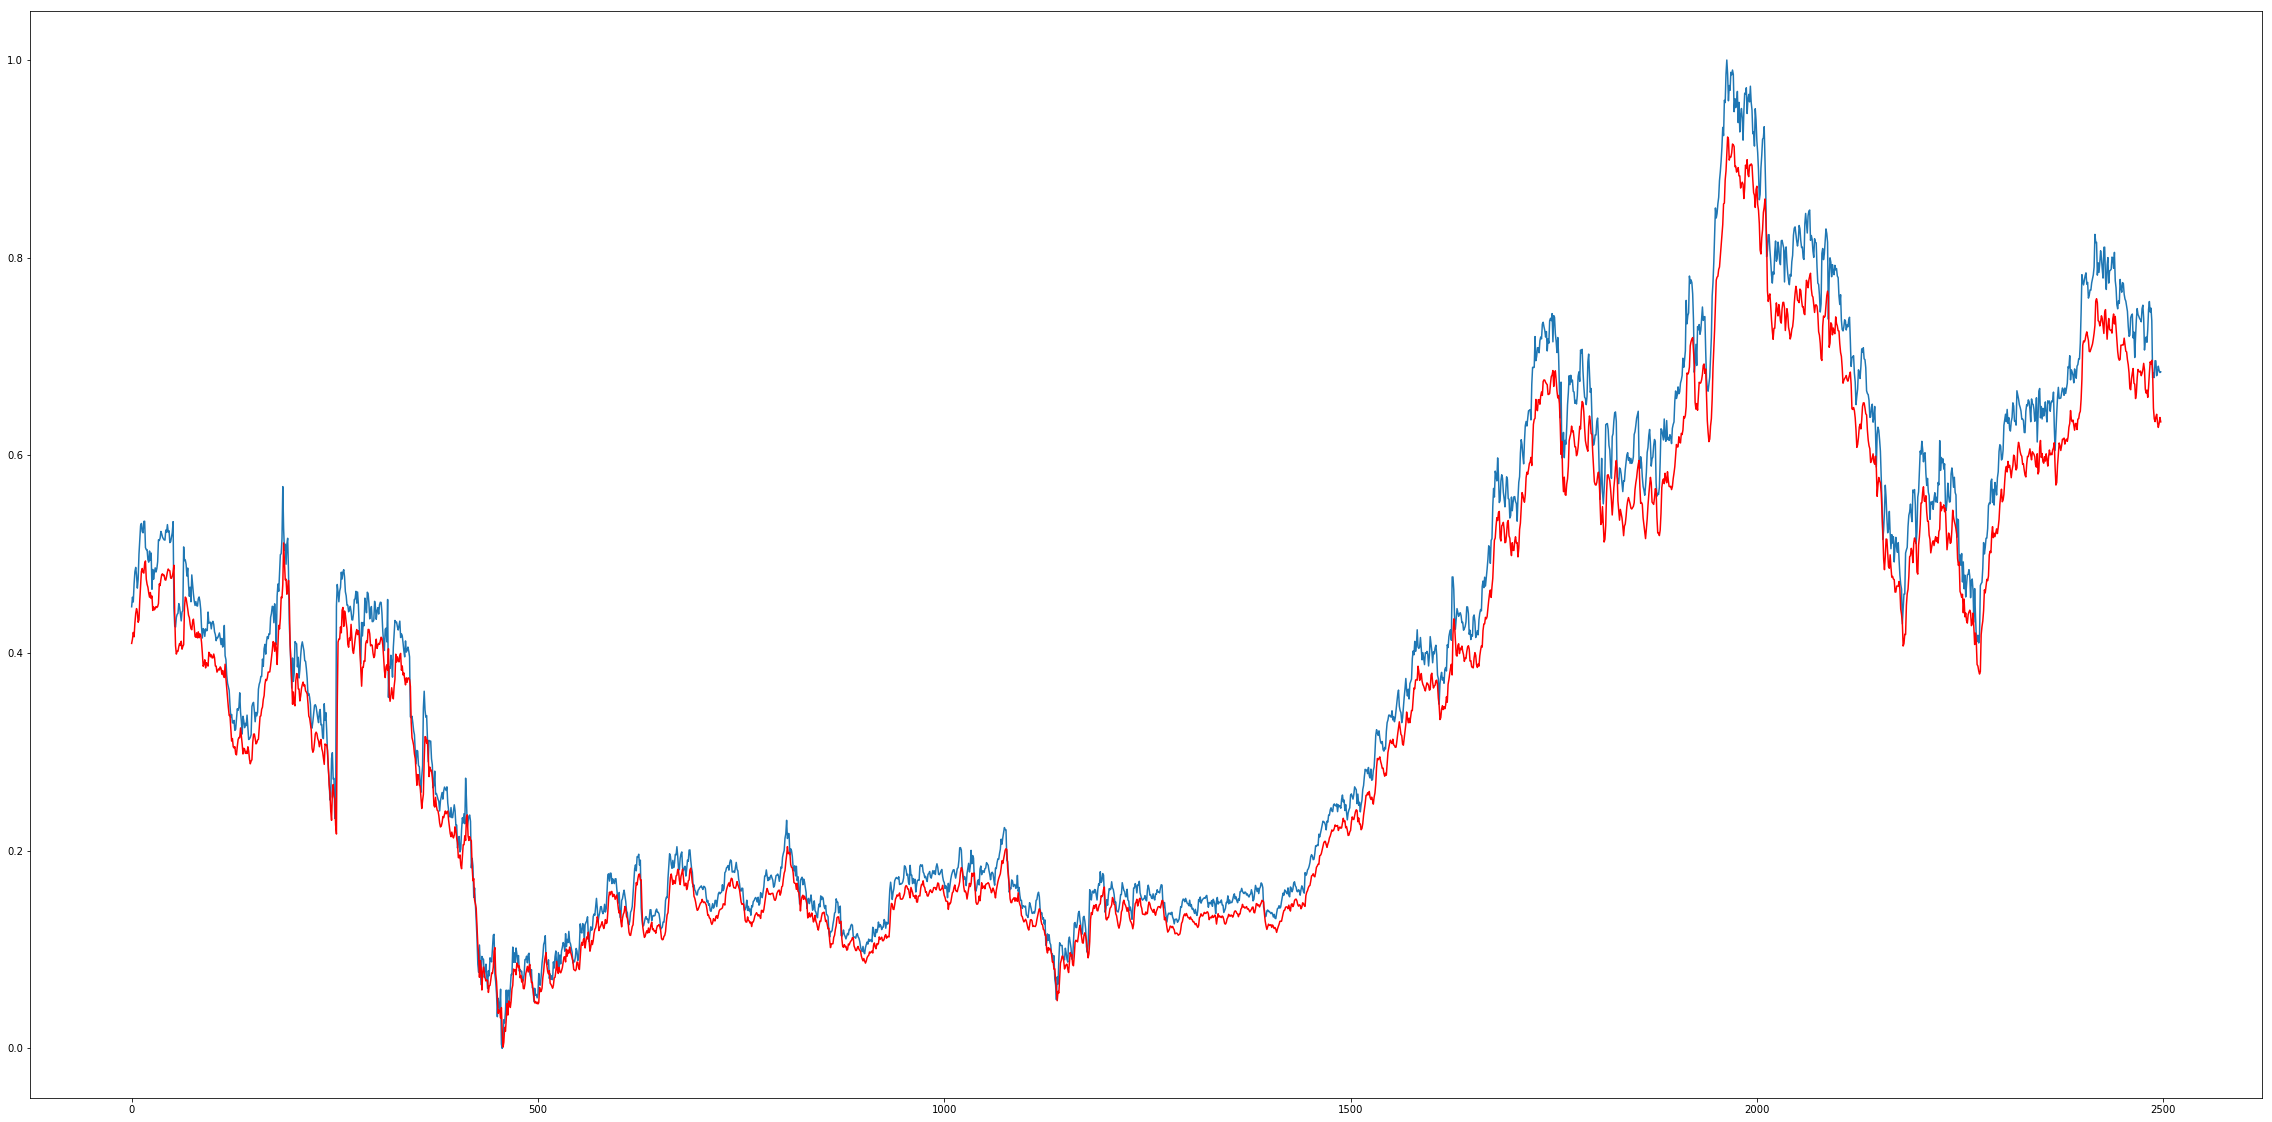

In [3]:
print(len(orderedX), len(orderedYHat_DENSE), len(orderedY))
print(len(dataset))
plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_DENSE[:], c = 'r')
plt.show()

Train on 2034 samples, validate on 227 samples
Epoch 1/15
1335s - loss: 0.0030 - val_loss: 8.6836e-04
Epoch 2/15
69s - loss: 4.0303e-04 - val_loss: 2.2581e-04
Epoch 3/15
66s - loss: 3.2522e-04 - val_loss: 2.4292e-04
Epoch 4/15
59s - loss: 2.7892e-04 - val_loss: 3.0548e-04
Epoch 5/15
59s - loss: 2.5533e-04 - val_loss: 4.4635e-04
Epoch 6/15
13527s - loss: 2.3953e-04 - val_loss: 1.7640e-04
Epoch 7/15
62s - loss: 2.2905e-04 - val_loss: 1.7979e-04
Epoch 8/15
61s - loss: 2.1878e-04 - val_loss: 1.7153e-04
Epoch 9/15
55s - loss: 2.0813e-04 - val_loss: 1.7810e-04
Epoch 10/15
61s - loss: 2.0710e-04 - val_loss: 3.0267e-04
Epoch 11/15
61s - loss: 1.9998e-04 - val_loss: 4.3148e-04
Epoch 12/15
63s - loss: 1.9981e-04 - val_loss: 2.0058e-04
Epoch 13/15
59s - loss: 1.9502e-04 - val_loss: 9.8831e-04
Epoch 14/15
56s - loss: 1.9207e-04 - val_loss: 2.6539e-04
Epoch 15/15
53s - loss: 1.8982e-04 - val_loss: 9.6470e-04


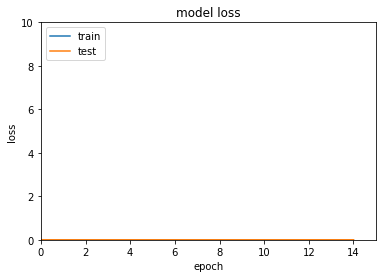

2256/2261 [============================>.] - ETA: 0s 

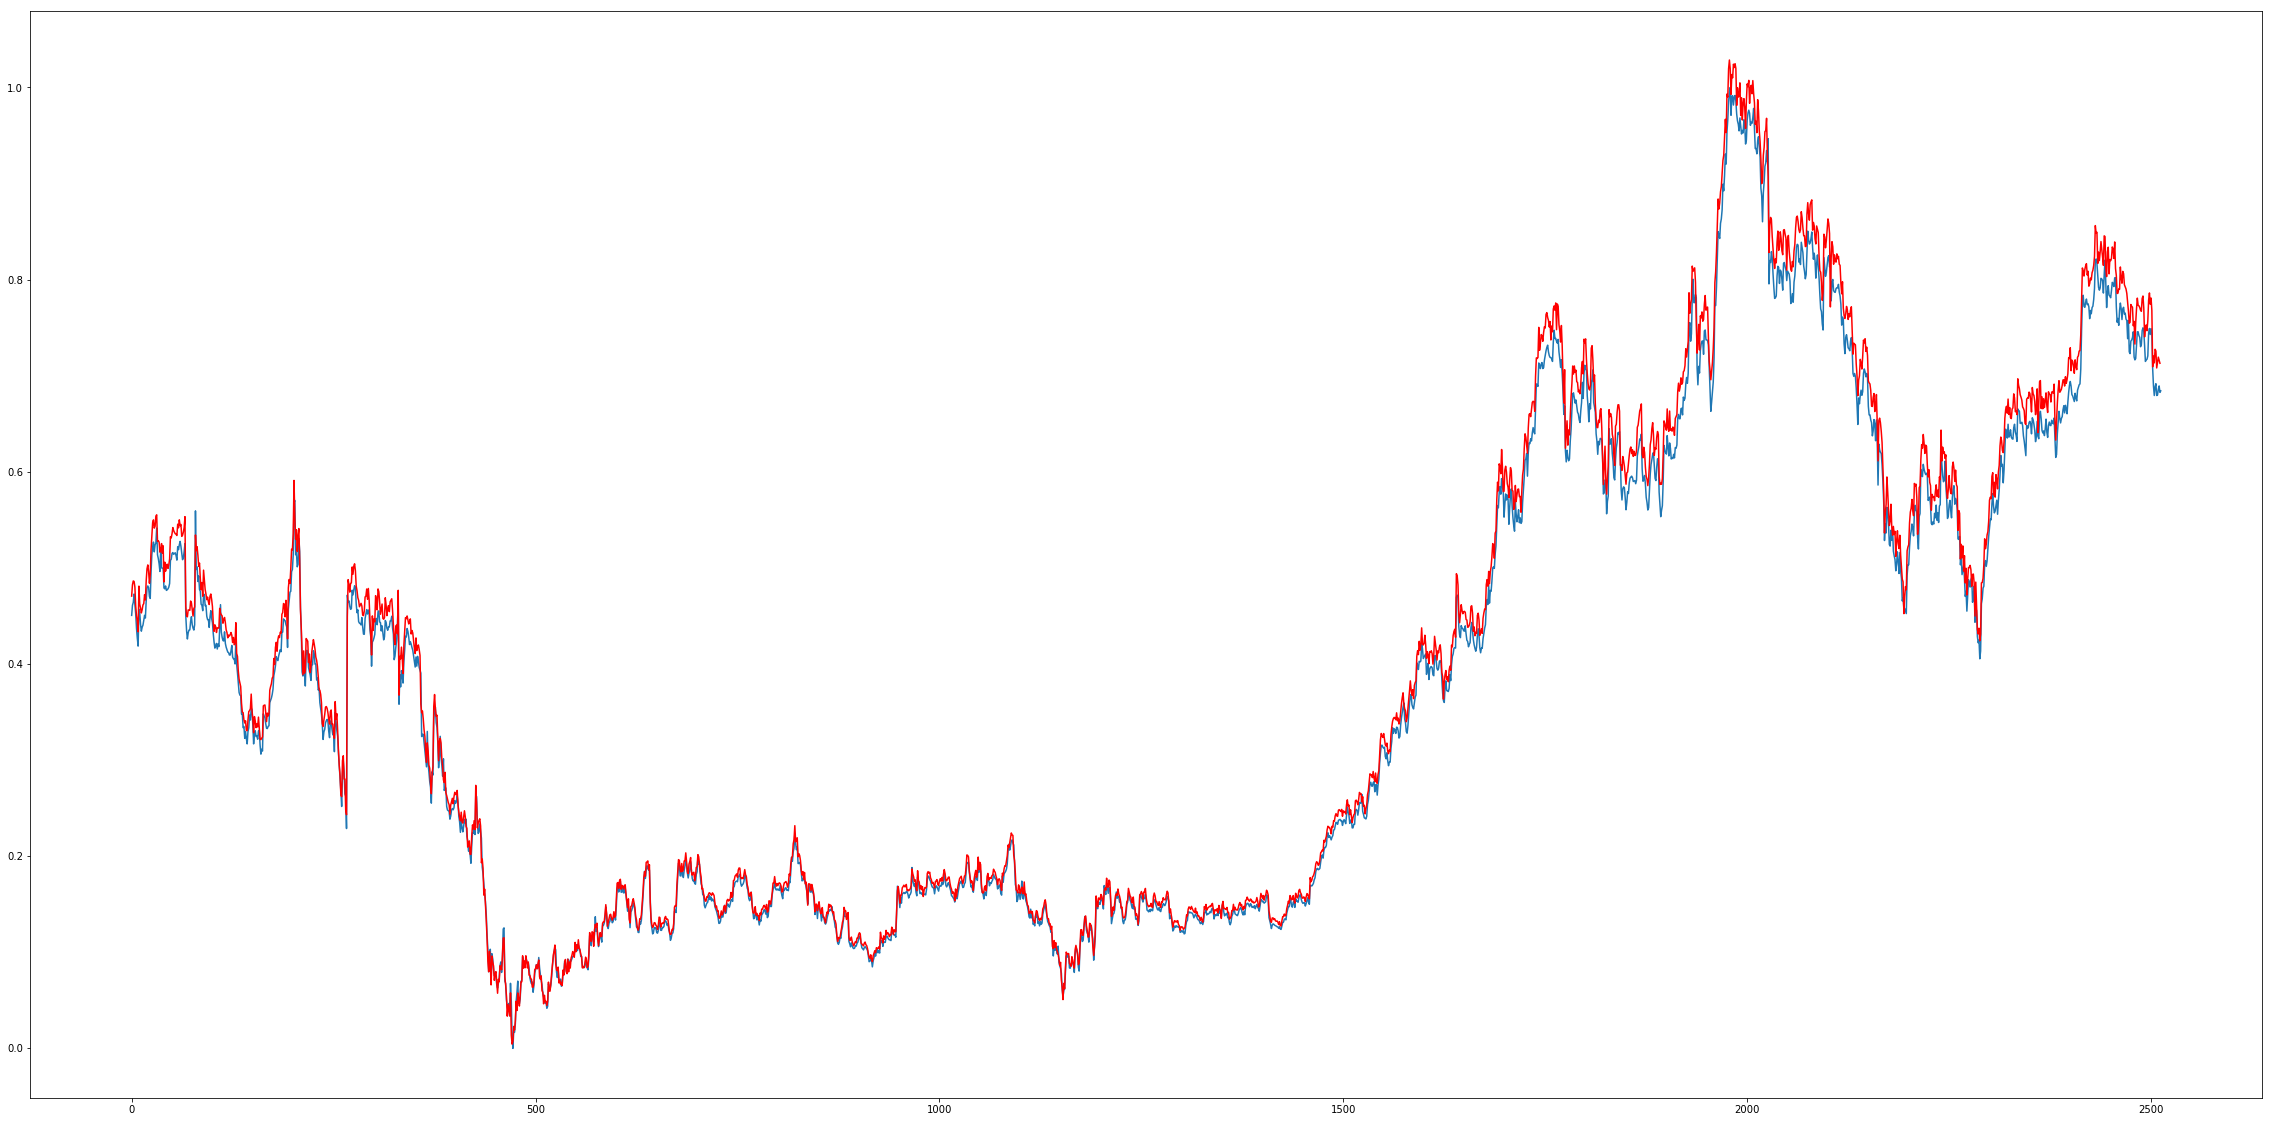

In [2]:
# Model 2, LSTM with multiple features
# LSTM tuning
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Convolution1D, Convolution2D
from keras.layers import Merge, LSTM, Dense 
np.random.seed(7) # fix random seed to ensure the results are reproducible
from copy import deepcopy

# reference from : http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# dataframe = pandas.read_csv('Yahoo+Nasdaq+SP500+DJ30-20100101-20161231.csv', usecols=['YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume'])
f = ['YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume']
dataframe = pandas.read_csv('YHOO_2007-2016.csv', usecols= f)
dataset = dataframe.values
# reverse the dataset by row, oldest date first
dataset = np.flip(dataset, 0) 
dataset.astype('float32')

# plot the dataset
# plt.title('Yahoo HighPrice - Date')
# plt.plot(dataset)
# plt.show()

# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split training and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:, :]

# convert an array of values into a dataset matrix
def create_ordered_dataset(dataset, look_back = 1):
    # dataset is in shape of (1762, 6)   
    # weights for the 6 input features 'YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume'
#     w = [0.01, 1, 0.01, 0.01, 0.01, 5*10e-10] 
    w = [1, 1, 1, 1, 1, 1]
    dataX= []
    dataY = []
    for i in range(len(dataset) - look_back):
        # A shallow copy might give me issue on weights     
        a = deepcopy(dataset[i:(i+look_back), :])   # shape of (20, 6) input length = 20, input dim = 6
        for m in range(len(a)):
            for n in range(len(a[m])):
                a[m][n] = a[m][n] * w[n]
        dataX.append(a)
        dataY.append(dataset[i+look_back][1]) # pick the next day's tuple, get Yahoo-High
    return np.array(dataX), np.array(dataY)

# reshape training and test set into X = t, Y = t + 1
# data dimension should be [dim1 - samples, dim2 - window size, dim3 - features]
look_back = 5 #18
batchSize = 1
epoch = 15
trainX, trainY = create_ordered_dataset(train, look_back)
testX, testY = create_ordered_dataset(test, look_back)
orderedX, orderedY = create_ordered_dataset(dataset, look_back)
# print('trainX.shape:')
# print(trainX[0][6])
# print('trainY.shape:')
# print(trainY.shape)
    
# create training network
# Reference: Which optimizer to use
# http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop
model = Sequential()
model.add(LSTM(20, input_dim = len(f), input_length = look_back, return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'rmsprop')
history = model.fit(trainX, trainY, batch_size=batchSize, nb_epoch=epoch, verbose = 2, validation_split=0.1)
# Reference for parameters: https://keras.io/models/sequential/

# Evaluation on MSE
    # With current parameter
    # MSE on trainX: 0.429521106769, MSE on testX: 0.610605459544
    # Graph of training and test mse, here training and test data are all in trainX
plt.axis((0, epoch, 0, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    # MSE on trainX and testX   
training_loss = model.evaluate(trainX, trainY, batch_size=batchSize, verbose = 1)
print("\nMSE on trainX: {}".format(training_loss))
test_loss = model.evaluate(testX, testY, batch_size=batchSize, verbose = 1)
print("\nMSE on testX: {}".format(test_loss))
cv = (np.sqrt(test_loss) / np.mean(testY)) * 100
print("Coefficient of Variation: ", cv, "%")

# Evaluation on Trend
orderedYHat_LSTM = model.predict(orderedX, batch_size = batchSize, verbose = 0);
# The YHat has one day delay compared with Y, that's the reason for previous bad performance
def evaluateY(Y, YHat):
    total = len(Y)
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    print("Trend prediction performance: {}%".format(count * 100.0 / total))
print('Overall:')
evaluateY(orderedY, orderedYHat_LSTM)    
print('Test Set Only:')
evaluateY(orderedY[train_size:], orderedYHat_LSTM[train_size:])  

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_LSTM[1:], c = 'r')
plt.show()

In [5]:
print(len(dataset), len(orderedX), len(orderedYHat_LSTM))

(2518, 2498, 2498)


(5000, 20, 1)
Begin
Train on 4750 samples, validate on 250 samples
Epoch 1/1
4750/4750 [==============================] - 5s - loss: 0.0025 - val_loss: 0.0012

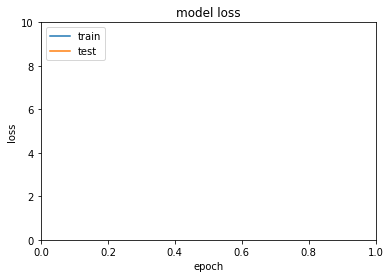

5000/5000 [==============================] - 1s     

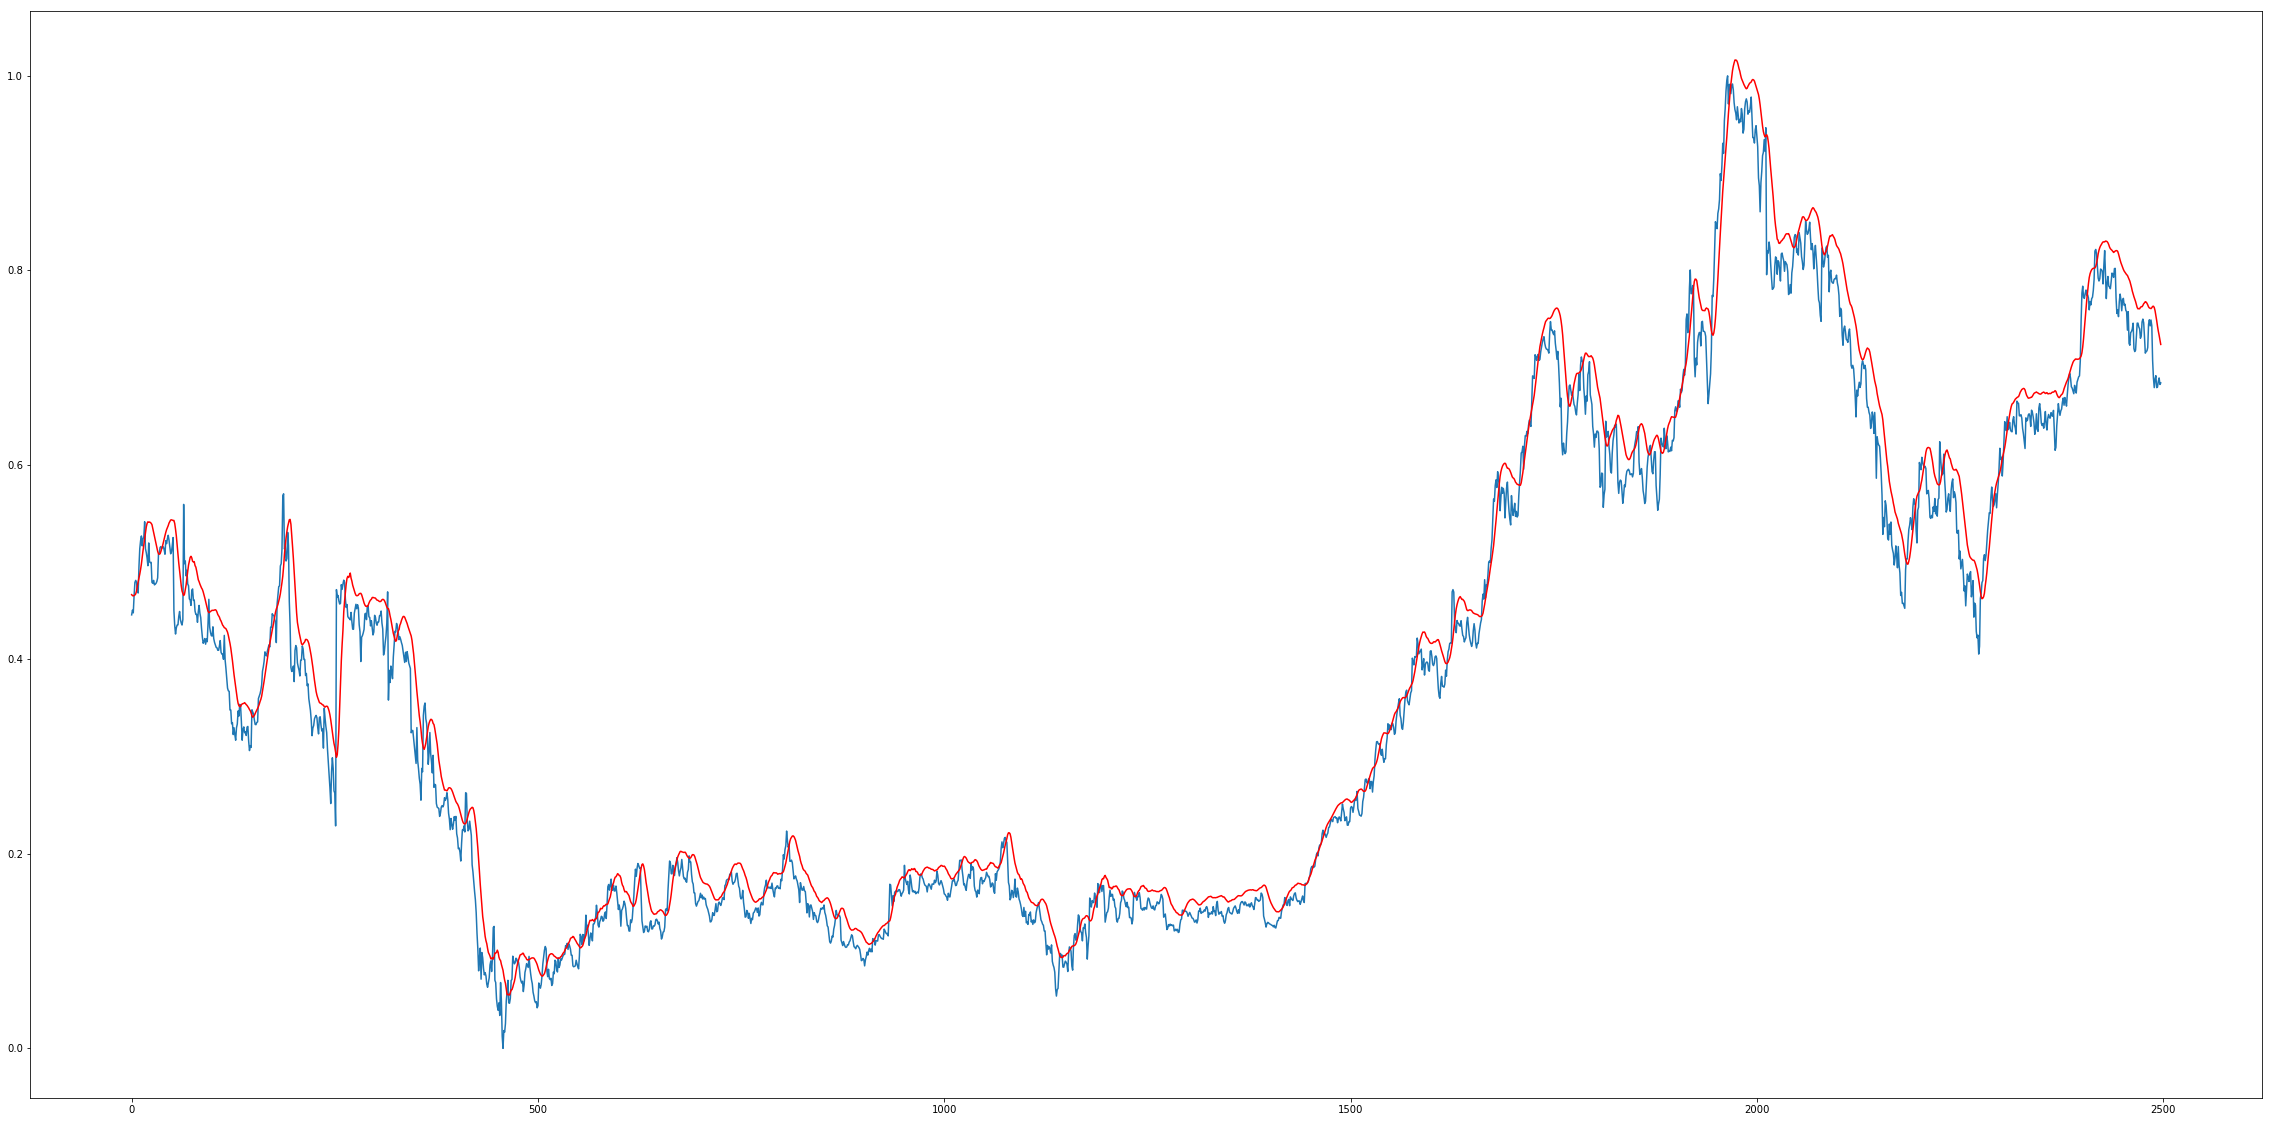

In [7]:
# Model 3, Cara's Convolutional NN with single feature
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Convolution1D, Convolution2D
from keras.regularizers import l2, activity_l2
from keras.layers import Merge, LSTM, Dense 
from keras.layers import Flatten
from copy import deepcopy
np.random.seed(7) # fix random seed to ensure the results are reproducible

# reference from : http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# dataframe = pandas.read_csv('Yahoo+Nasdaq+SP500+DJ30-20100101-20161231.csv', usecols=['YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume'])
dataframe = pandas.read_csv('YHOO_2007-2016.csv', usecols=['YHOO-High'])
dataset = dataframe.values
# reverse the dataset by row, oldest date first
dataset = np.flip(dataset, 0) 
dataset.astype('float32')

# plot the dataset
# plt.title('Yahoo HighPrice - Date')
# plt.plot(dataset)
# plt.show()

# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split training and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:, :]
# convert an array of values into a dataset matrix
def create_random_dataset(dataset, look_back = 1, iteration_time = 1):
    dataX, dataY = [], []
    for i in range(iteration_time):
        start = randint(0, len(dataset)-look_back-1) # randint(a,b), a <= x <= b
        a = dataset[start:(start+look_back), :]
        dataX.append(a)
        dataY.append(dataset[start+look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_ordered_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = deepcopy(dataset[i:(i+look_back), :])
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape training and test set into X = t, Y = t + 1
look_back = 20
iteration_time = 5000
trainX, trainY = create_random_dataset(train, look_back, iteration_time)
testX, testY = create_random_dataset(test, look_back, 6)
orderedX, orderedY = create_ordered_dataset(dataset, look_back) # this is used for trend evaluation

# transform data into two dim input. Since it's already 2d, this part is useless. 
# If more features are used, we need this part to increase the dimension
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
orderedX = np.reshape(orderedX, (orderedX.shape[0], orderedX.shape[1], 1))
# print(trainX[0:5])
print(trainX.shape)

# # create training network
# # Reference: Which optimizer to use
# # http://sebastianruder.com/optimizing-gradient-descent/index.html #rmsprop
batchSize = 5
epoch = 1
print("Begin")
model = Sequential()
model.add(Convolution1D(24, 5, border_mode='valid', input_shape=(look_back, 1), activation='relu'))
model.add(Convolution1D(24, 5, activation='relu'))
model.add(Flatten())
# model.add(Dense(25, input_shape=(look_back,)))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse') # can try optimizer = 'adam'
history = model.fit(trainX, trainY, validation_split=0.05, batch_size=batchSize, nb_epoch=epoch, initial_epoch=0, verbose = 1)
print("Finish")

# Evaluation on MSE
    # With current parameter
    # MSE on trainX: 0.429521106769, MSE on testX: 0.610605459544
    # Graph of training and test mse, here training and test data are all in trainX
plt.axis((0, epoch, 0, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    # MSE on trainX and testX   
training_loss = model.evaluate(trainX, trainY, batch_size=batchSize, verbose = 1)
print("\nMSE on trainX: {}".format(training_loss))
test_loss = model.evaluate(testX, testY, batch_size=batchSize, verbose = 1)
print("\nMSE on testX: {}".format(test_loss))
cv = (np.sqrt(test_loss) / np.mean(testY)) * 100
print("Coefficient of Variation: ", cv, "%")

# Evaluation on Trend
orderedYHat_CONV = model.predict(orderedX, batch_size = batchSize, verbose = 0);
# The YHat has one day delay compared with Y, that's the reason for previous bad performance
def evaluateY(Y, YHat):
    total = len(Y)
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    print("Trend prediction performance: {}%".format(count * 100.0 / total))
print('Overall:')
evaluateY(orderedY, orderedYHat_CONV)    
print('Test Set Only:')
evaluateY(orderedY[train_size:], orderedYHat_CONV[train_size:])  

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_CONV[0:], c = 'r')
plt.show()

# predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# denormalization
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform(trainY)
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform(testY)

trainX.shape:
(1742, 20, 6)
trainY.shape:
(1742,)
Train on 1567 samples, validate on 175 samples
Epoch 1/25
1s - loss: 0.0040 - val_loss: 0.0070
Epoch 2/25
0s - loss: 0.0023 - val_loss: 0.0010
Epoch 3/25
0s - loss: 0.0017 - val_loss: 9.0017e-04
Epoch 4/25
0s - loss: 0.0014 - val_loss: 0.0062
Epoch 5/25
0s - loss: 0.0013 - val_loss: 4.4969e-04
Epoch 6/25
0s - loss: 0.0012 - val_loss: 0.0022
Epoch 7/25
0s - loss: 0.0010 - val_loss: 9.2571e-04
Epoch 8/25
0s - loss: 8.7746e-04 - val_loss: 0.0190
Epoch 9/25
0s - loss: 6.9865e-04 - val_loss: 8.8065e-04
Epoch 10/25
0s - loss: 8.1022e-04 - val_loss: 2.2075e-04
Epoch 11/25
0s - loss: 6.7711e-04 - val_loss: 0.0052
Epoch 12/25
0s - loss: 6.7747e-04 - val_loss: 0.0039
Epoch 13/25
0s - loss: 5.9092e-04 - val_loss: 0.0146
Epoch 14/25
0s - loss: 5.0954e-04 - val_loss: 0.0042
Epoch 15/25
0s - loss: 5.8741e-04 - val_loss: 0.0014
Epoch 16/25
0s - loss: 4.8497e-04 - val_loss: 9.4836e-04
Epoch 17/25
0s - loss: 4.7033e-04 - val_loss: 2.7053e-04
Epoch 18/25

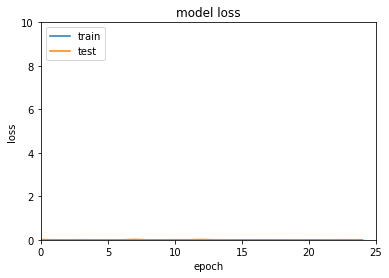

1340/1742 [======================>.......] - ETA: 0s
MSE on trainX: 0.000338301427919
700/736 [===========================>..] - ETA: 0s
MSE on testX: 0.00566024094318
Overall:
Trend prediction performance: 59.0872698159%
Test Set Only:
Trend prediction performance: 58.9673913043%


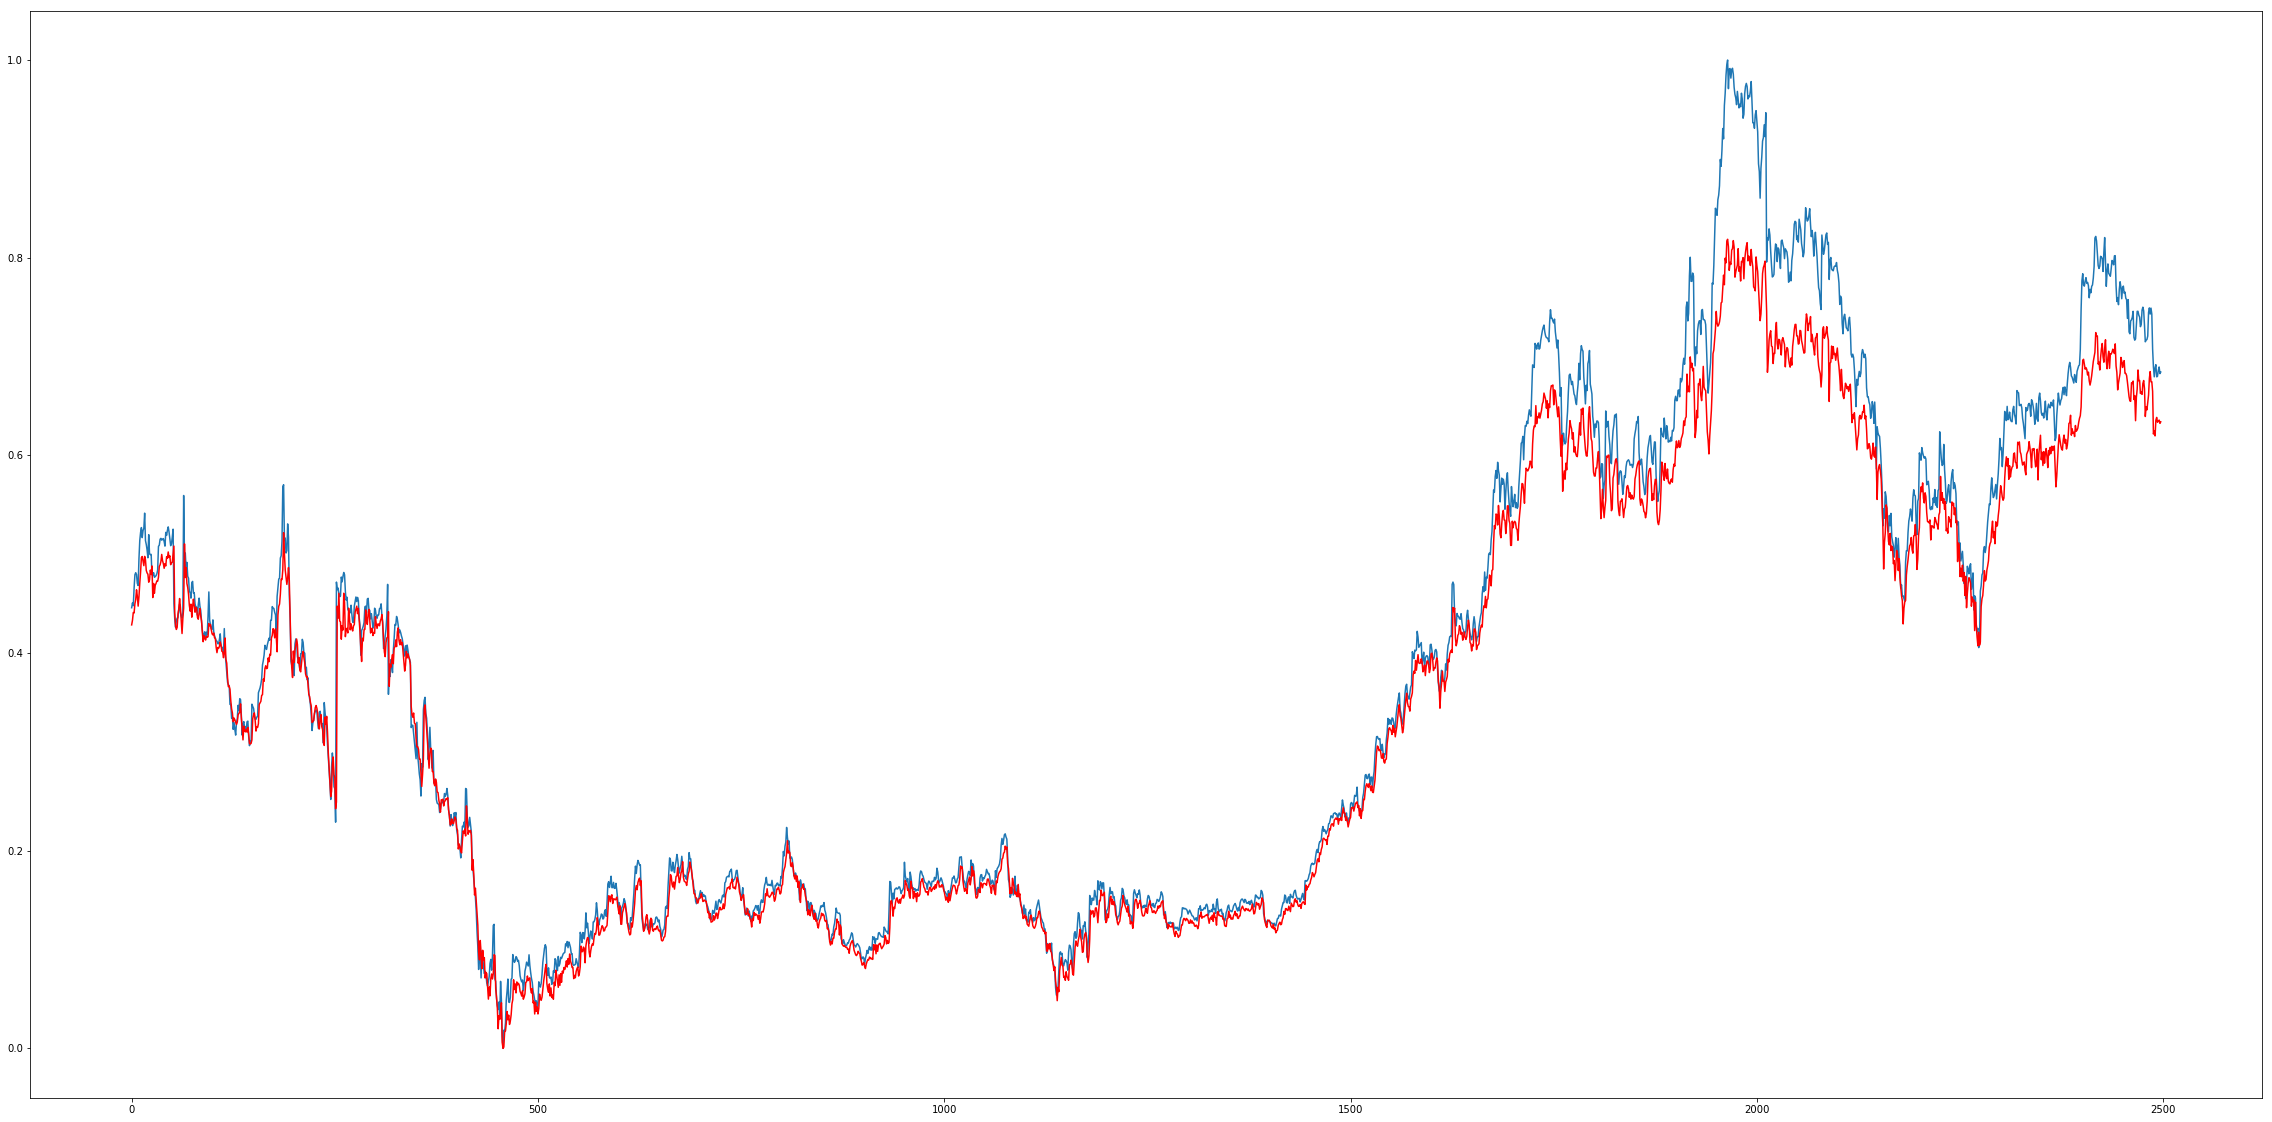

In [8]:
# Part 4, Cara 2
# Conv tuning
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Convolution1D, Convolution2D
from keras.layers import Merge, LSTM, Dense 
np.random.seed(7) # fix random seed to ensure the results are reproducible
from copy import deepcopy
from keras.layers import Flatten
# reference from : http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# dataframe = pandas.read_csv('Yahoo+Nasdaq+SP500+DJ30-20100101-20161231.csv', usecols=['YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume'])
f = ['YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume']
dataframe = pandas.read_csv('YHOO_2007-2016.csv', usecols=f)
list(dataframe)
dataset = dataframe.values
#reverse the dataset by row, oldest date first
dataset = np.flip(dataset, 0) 
dataset.astype('float32')

# plot the dataset
# plt.title('Yahoo HighPrice - Date')
# plt.plot(dataset)
# plt.show()

# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split training and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:, :]

# convert an array of values into a dataset matrix
def create_ordered_dataset(dataset, look_back = 1):
    # dataset is in shape of (1762, 6)   
    # weights for the 6 input features 'YHOO-Open', 'YHOO-High', 'YHOO-Low', 'YHOO-Close', 'YHOO-Adj_Close', 'YHOO-Volume'
    w = [0.01, 1, 0.01, 0.01, 0.01, 5*10e-10] 
    dataX= []
    dataY = []
    for i in range(len(dataset) - look_back):
        # A shallow copy might give me issue on weights     
        a = deepcopy(dataset[i:(i+look_back), :])   # shape of (20, 6) input length = 20, input dim = 6
        for m in range(len(a)):
            for n in range(len(a[m])):
                a[m][n] = a[m][n] * 1 #w[n]
        dataX.append(a)
        dataY.append(dataset[i+look_back][1]) # pick the next day's tuple, get Yahoo-High
    return np.array(dataX), np.array(dataY)

# reshape training and test set into X = t, Y = t + 1
# data dimension should be [dim1 - samples, dim2 - window size, dim3 - features]
look_back = 20
batchSize = 20
epoch = 25
trainX, trainY = create_ordered_dataset(train, look_back)
testX, testY = create_ordered_dataset(test, look_back)
orderedX, orderedY = create_ordered_dataset(dataset, look_back)
print('trainX.shape:')
print(trainX.shape)
print('trainY.shape:')
print(trainY.shape)
    
# create training network
# Reference: Which optimizer to use
# http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop
model = Sequential()
# model.add(LSTM(output_dim = len(f), input_dim = len(f), input_length = look_back, return_sequences=True))
# model.add(LSTM(output_dim = len(f), input_dim = len(f), input_length = look_back, return_sequences=False))
model.add(Convolution1D(25, 5, border_mode='valid', input_shape=(look_back, trainX.shape[2]), activation='tanh'))
model.add(Convolution1D(30, 5, activation='tanh'))
model.add(Flatten())
model.add(Dense(15))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'rmsprop')
history = model.fit(trainX, trainY, batch_size=batchSize, nb_epoch=epoch, verbose = 2, validation_split=0.1)
# Reference for parameters: https://keras.io/models/sequential/

# Evaluation on MSE
    # With current parameter
    # MSE on trainX: 0.429521106769, MSE on testX: 0.610605459544
    # Graph of training and test mse, here training and test data are all in trainX
plt.axis((0, epoch, 0, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    # MSE on trainX and testX   
training_loss = model.evaluate(trainX, trainY, batch_size=batchSize, verbose = 1)
print("\nMSE on trainX: {}".format(training_loss))
test_loss = model.evaluate(testX, testY, batch_size=batchSize, verbose = 1)
print("\nMSE on testX: {}".format(test_loss))

# Evaluation on Trend
orderedYHat_CARA2 = model.predict(orderedX, batch_size = batchSize, verbose = 0);
# The YHat has one day delay compared with Y, that's the reason for previous bad performance
def evaluateY(Y, YHat):
    total = min(len(YHat), len(Y))
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    print("Trend prediction performance: {}%".format(count * 100.0 / total))
print('Overall:')
evaluateY(orderedY, orderedYHat_CARA2)    
print('Test Set Only:')
evaluateY(orderedY[train_size:], orderedYHat_CARA2[train_size:])  

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_CARA2[:], c = 'r')
plt.show()

In [16]:
print(orderedYHat_CARA2.shape)
orderedYHat_LSTM = orderedYHat_LSTM.ravel()
orderedYHat_CONV = orderedYHat_CONV.ravel()
orderedYHat_DENSE = orderedYHat_DENSE.ravel()
orderedYHat_CARA2 = orderedYHat_CARA2.ravel()
lenLSTM, lenCONV, lenDENSE, lenCARA2 = orderedYHat_LSTM.shape[0], orderedYHat_CONV.shape[0], orderedYHat_DENSE.shape[0], orderedYHat_CARA2.shape[0]
print(lenLSTM, lenCONV, lenDENSE, lenCARA2)

YLen = min(lenLSTM, lenCONV, lenCARA2, lenDENSE, len(orderedY)) 
print(YLen)


(2498, 1)
(2498, 2498, 2498, 2498)
2498


Epoch 1/30
2248/2248 [==============================] - 9s - loss: 0.0997     
Epoch 2/30
2248/2248 [==============================] - 9s - loss: 2.5124e-04     
Epoch 3/30
2248/2248 [==============================] - 9s - loss: 2.4656e-04     
Epoch 4/30
2248/2248 [==============================] - 9s - loss: 2.3630e-04     
Epoch 5/30
2248/2248 [==============================] - 8s - loss: 2.3357e-04     
Epoch 6/30
2248/2248 [==============================] - 9s - loss: 2.2879e-04     
Epoch 7/30
2248/2248 [==============================] - 9s - loss: 2.2224e-04     
Epoch 8/30
2248/2248 [==============================] - 11s - loss: 2.2271e-04    
Epoch 9/30
2248/2248 [==============================] - 13s - loss: 2.0921e-04    
Epoch 10/30
2248/2248 [==============================] - 8s - loss: 2.0752e-04     
Epoch 11/30
2248/2248 [==============================] - 9s - loss: 2.0387e-04     
Epoch 12/30
2248/2248 [==============================] - 9s - loss: 2.0336e-04     
Epoch

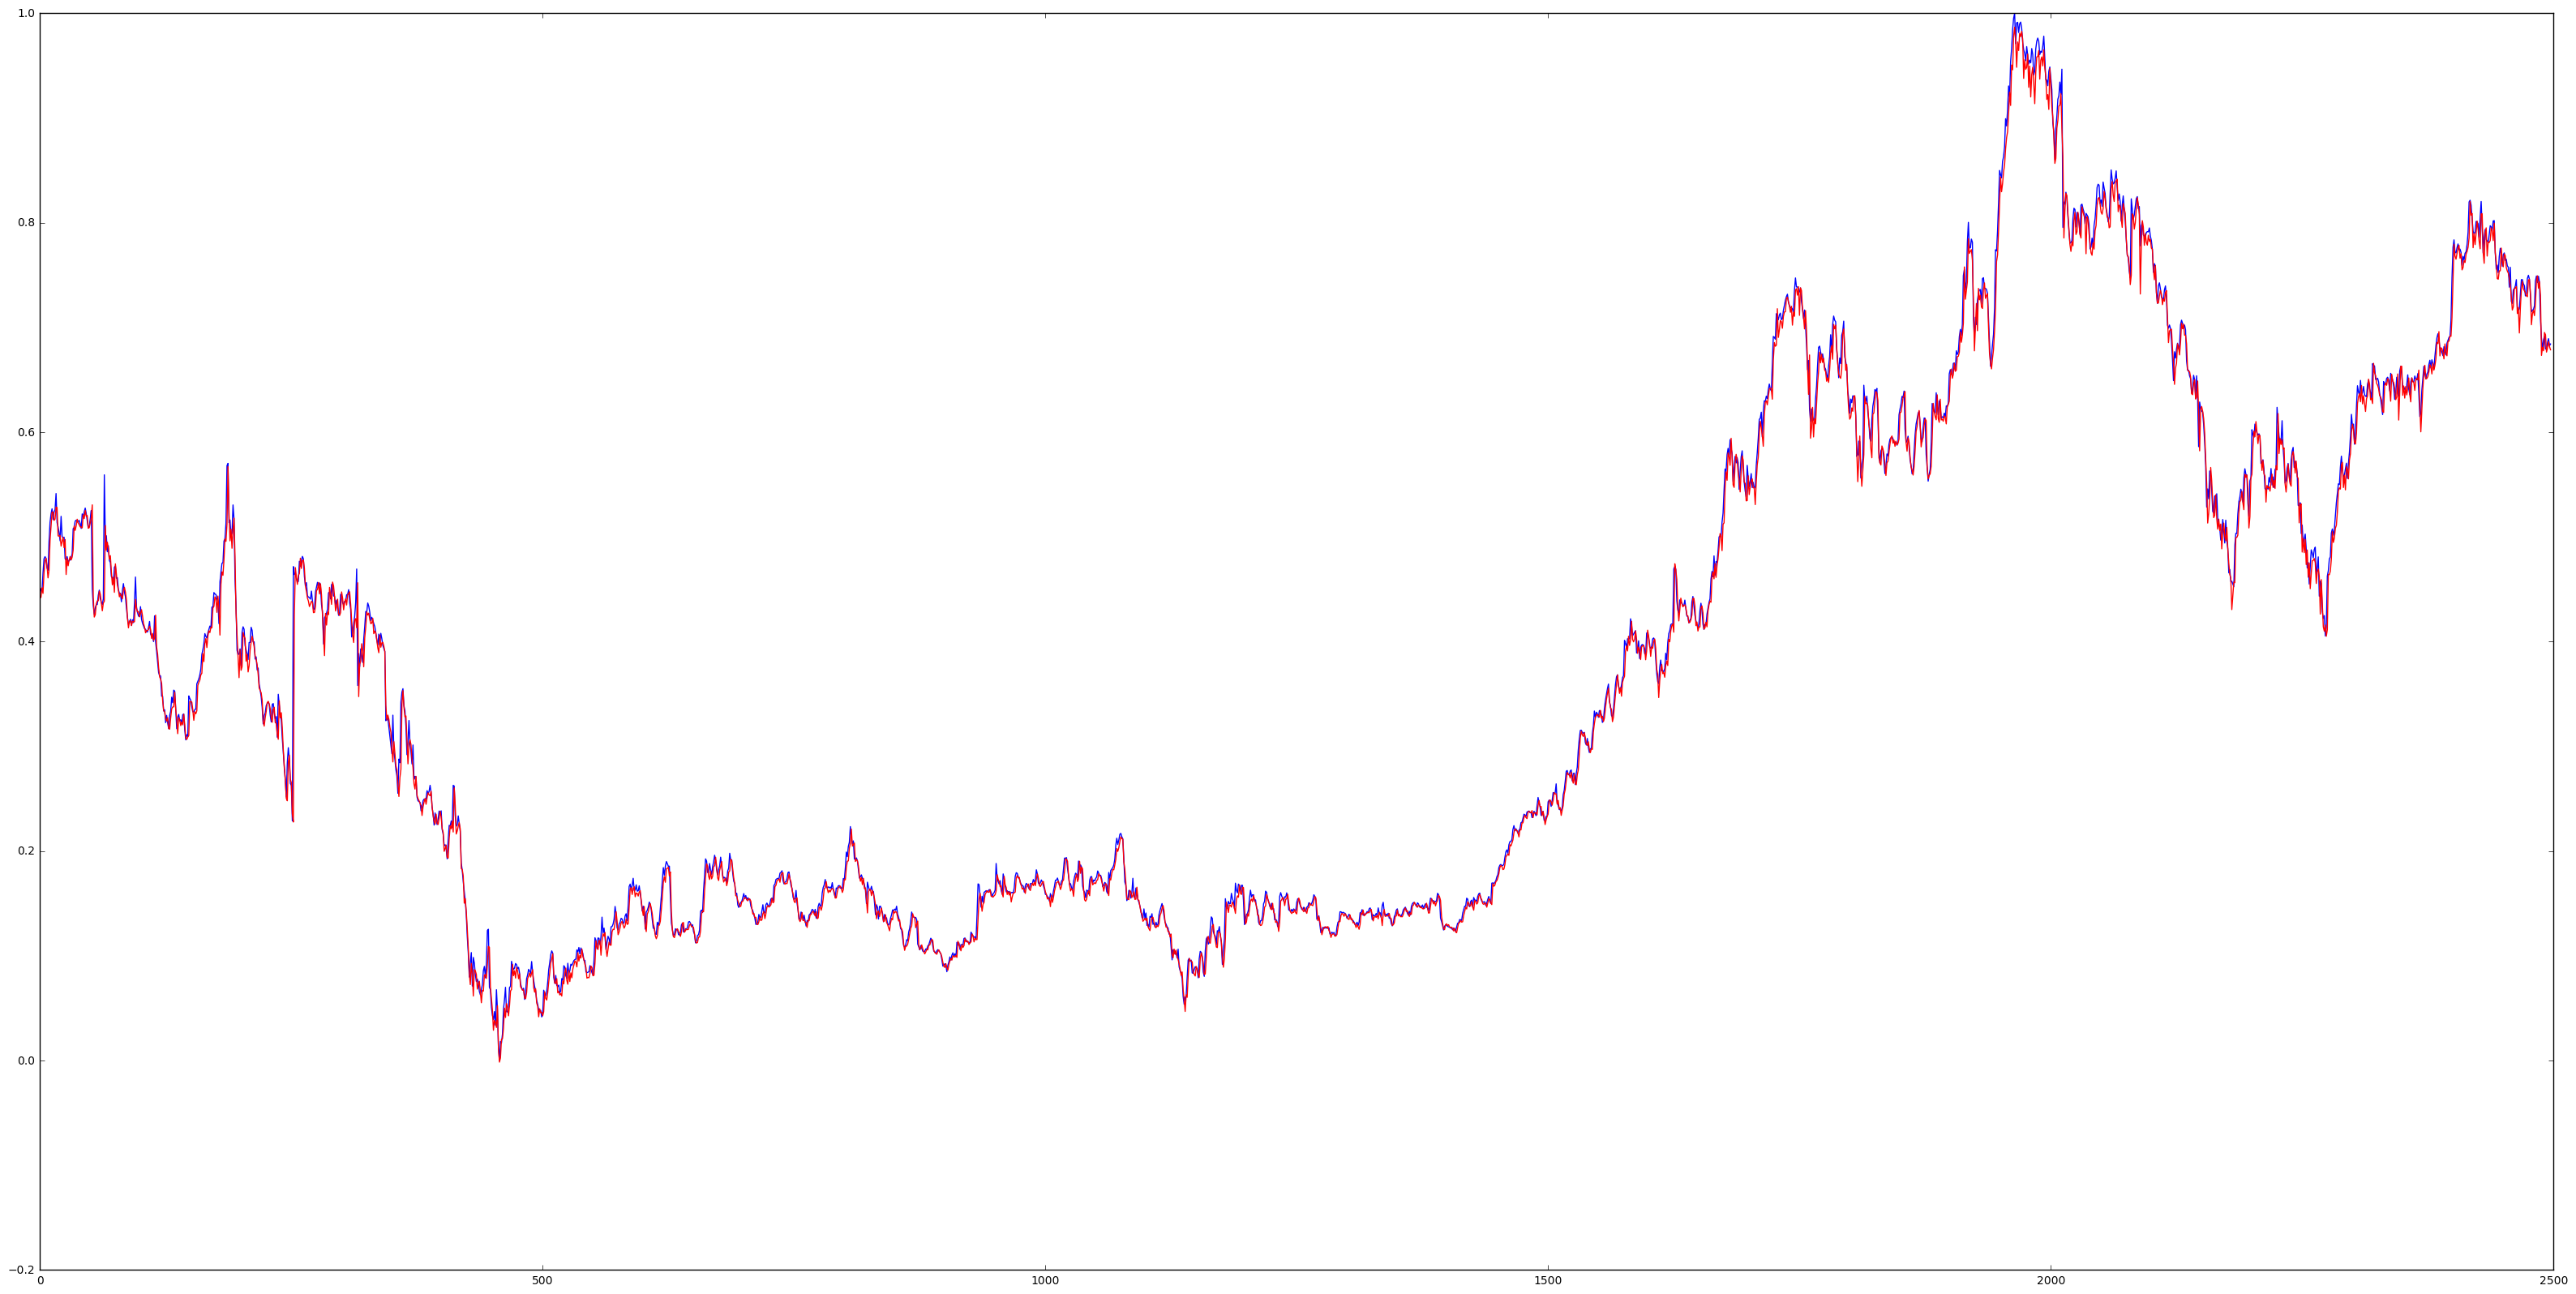

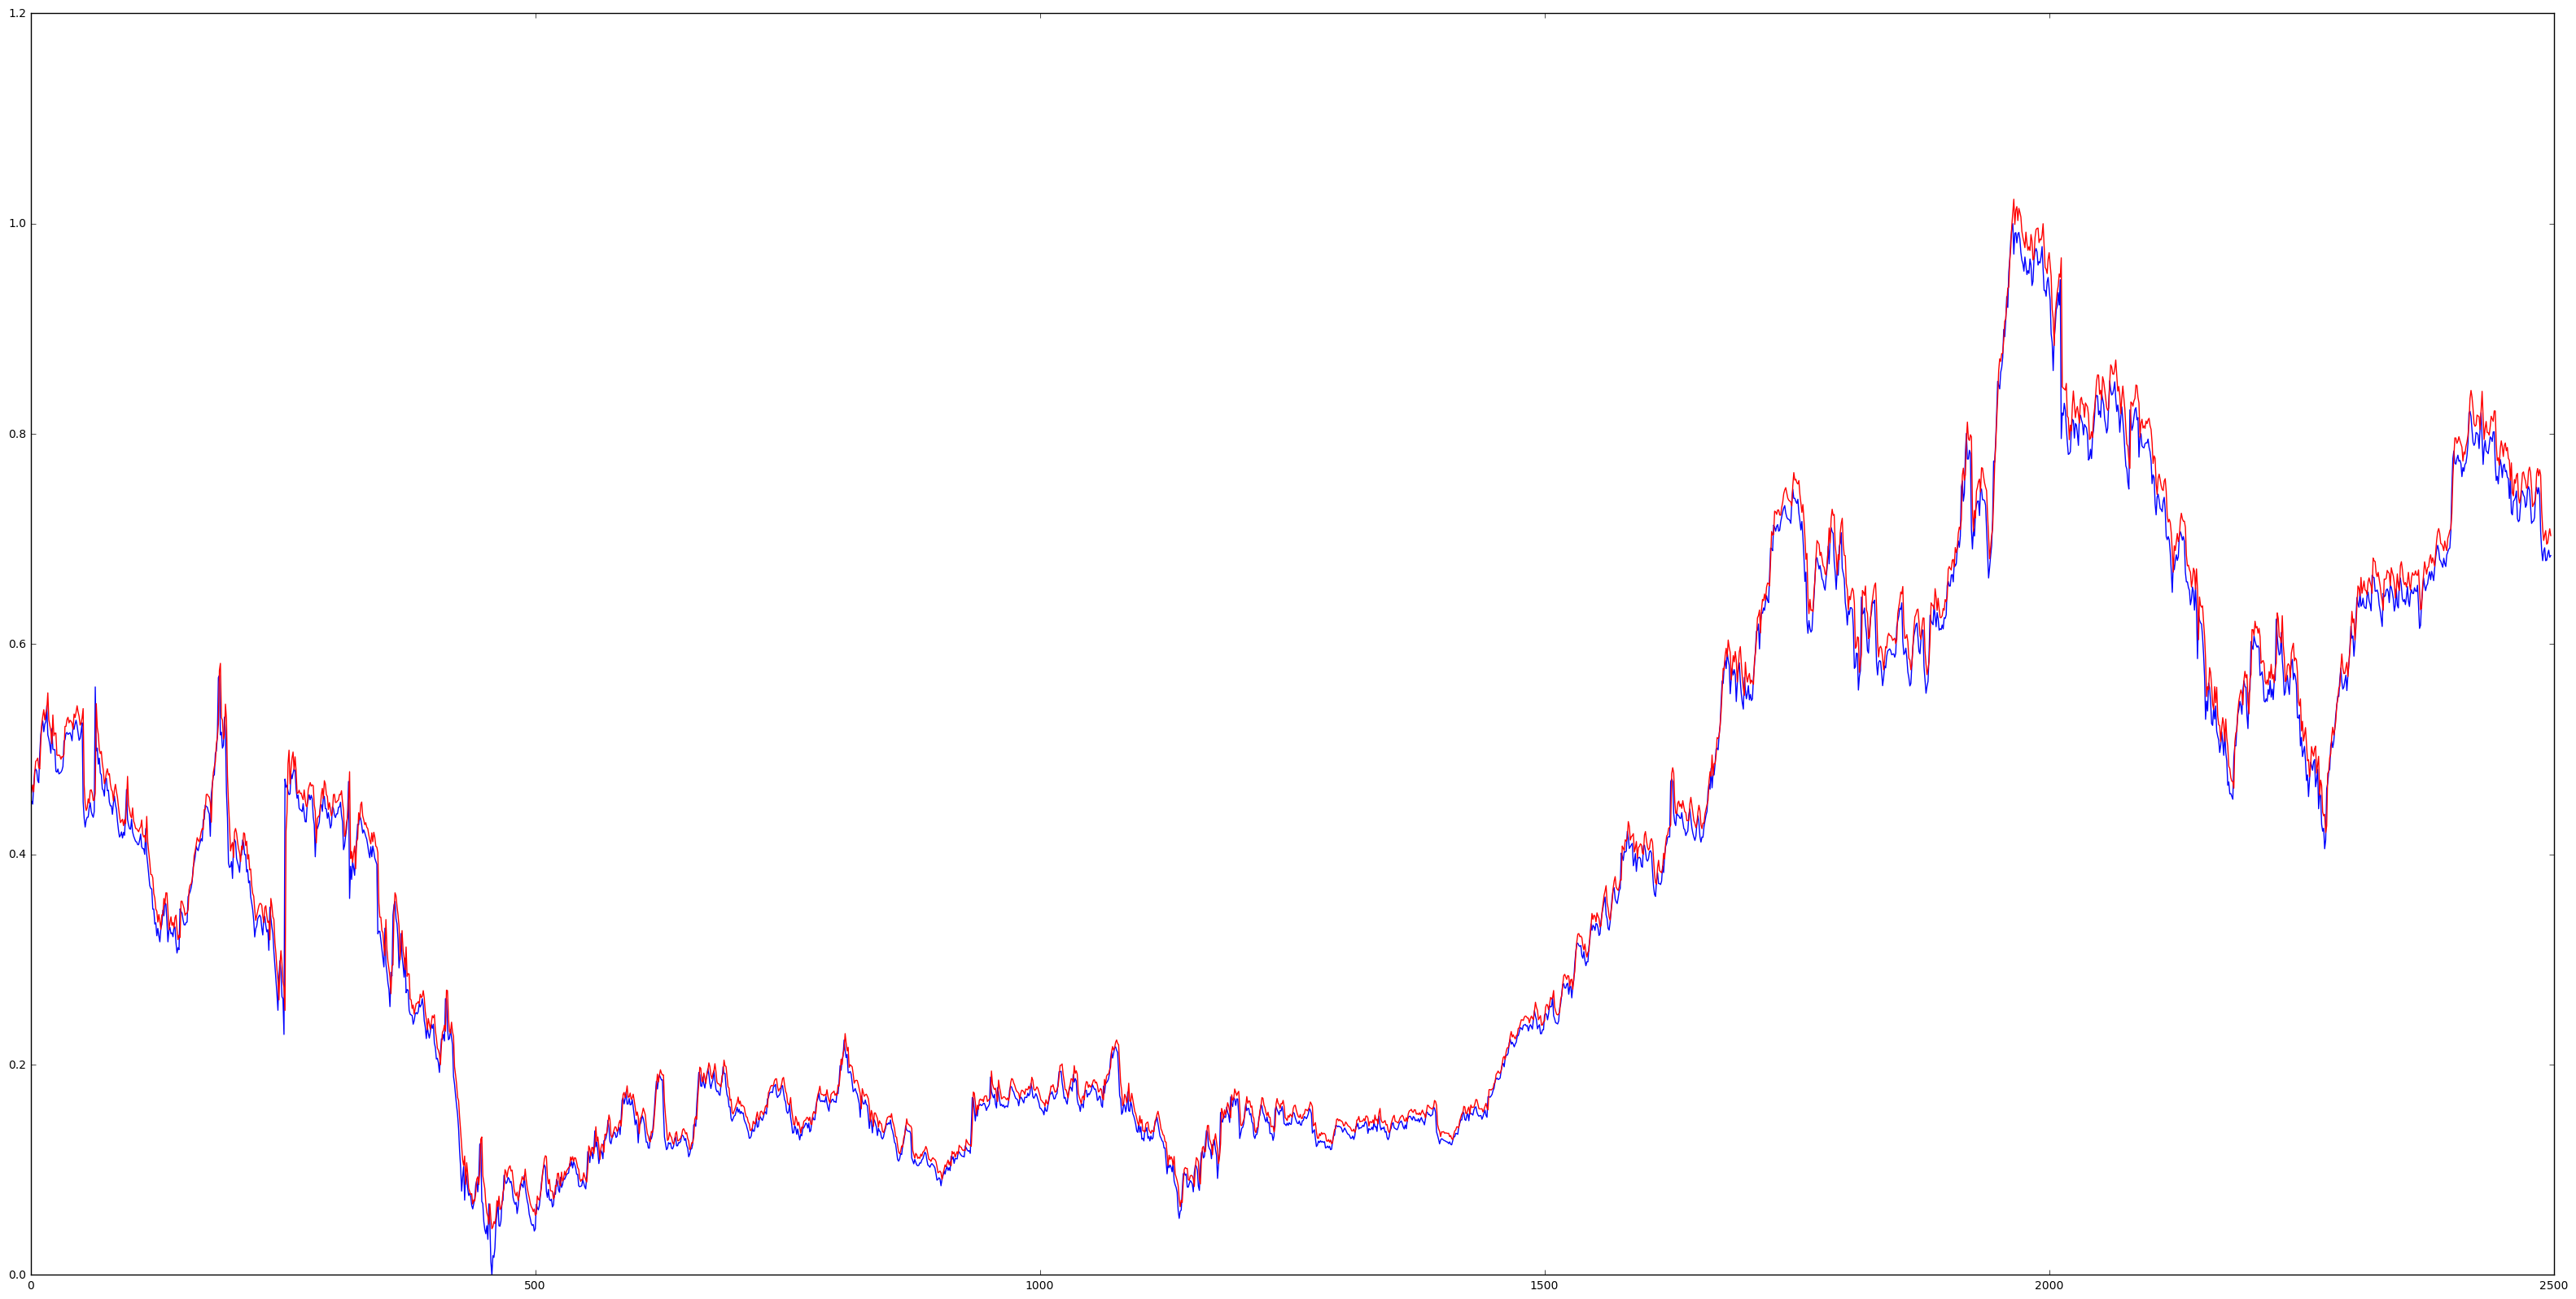

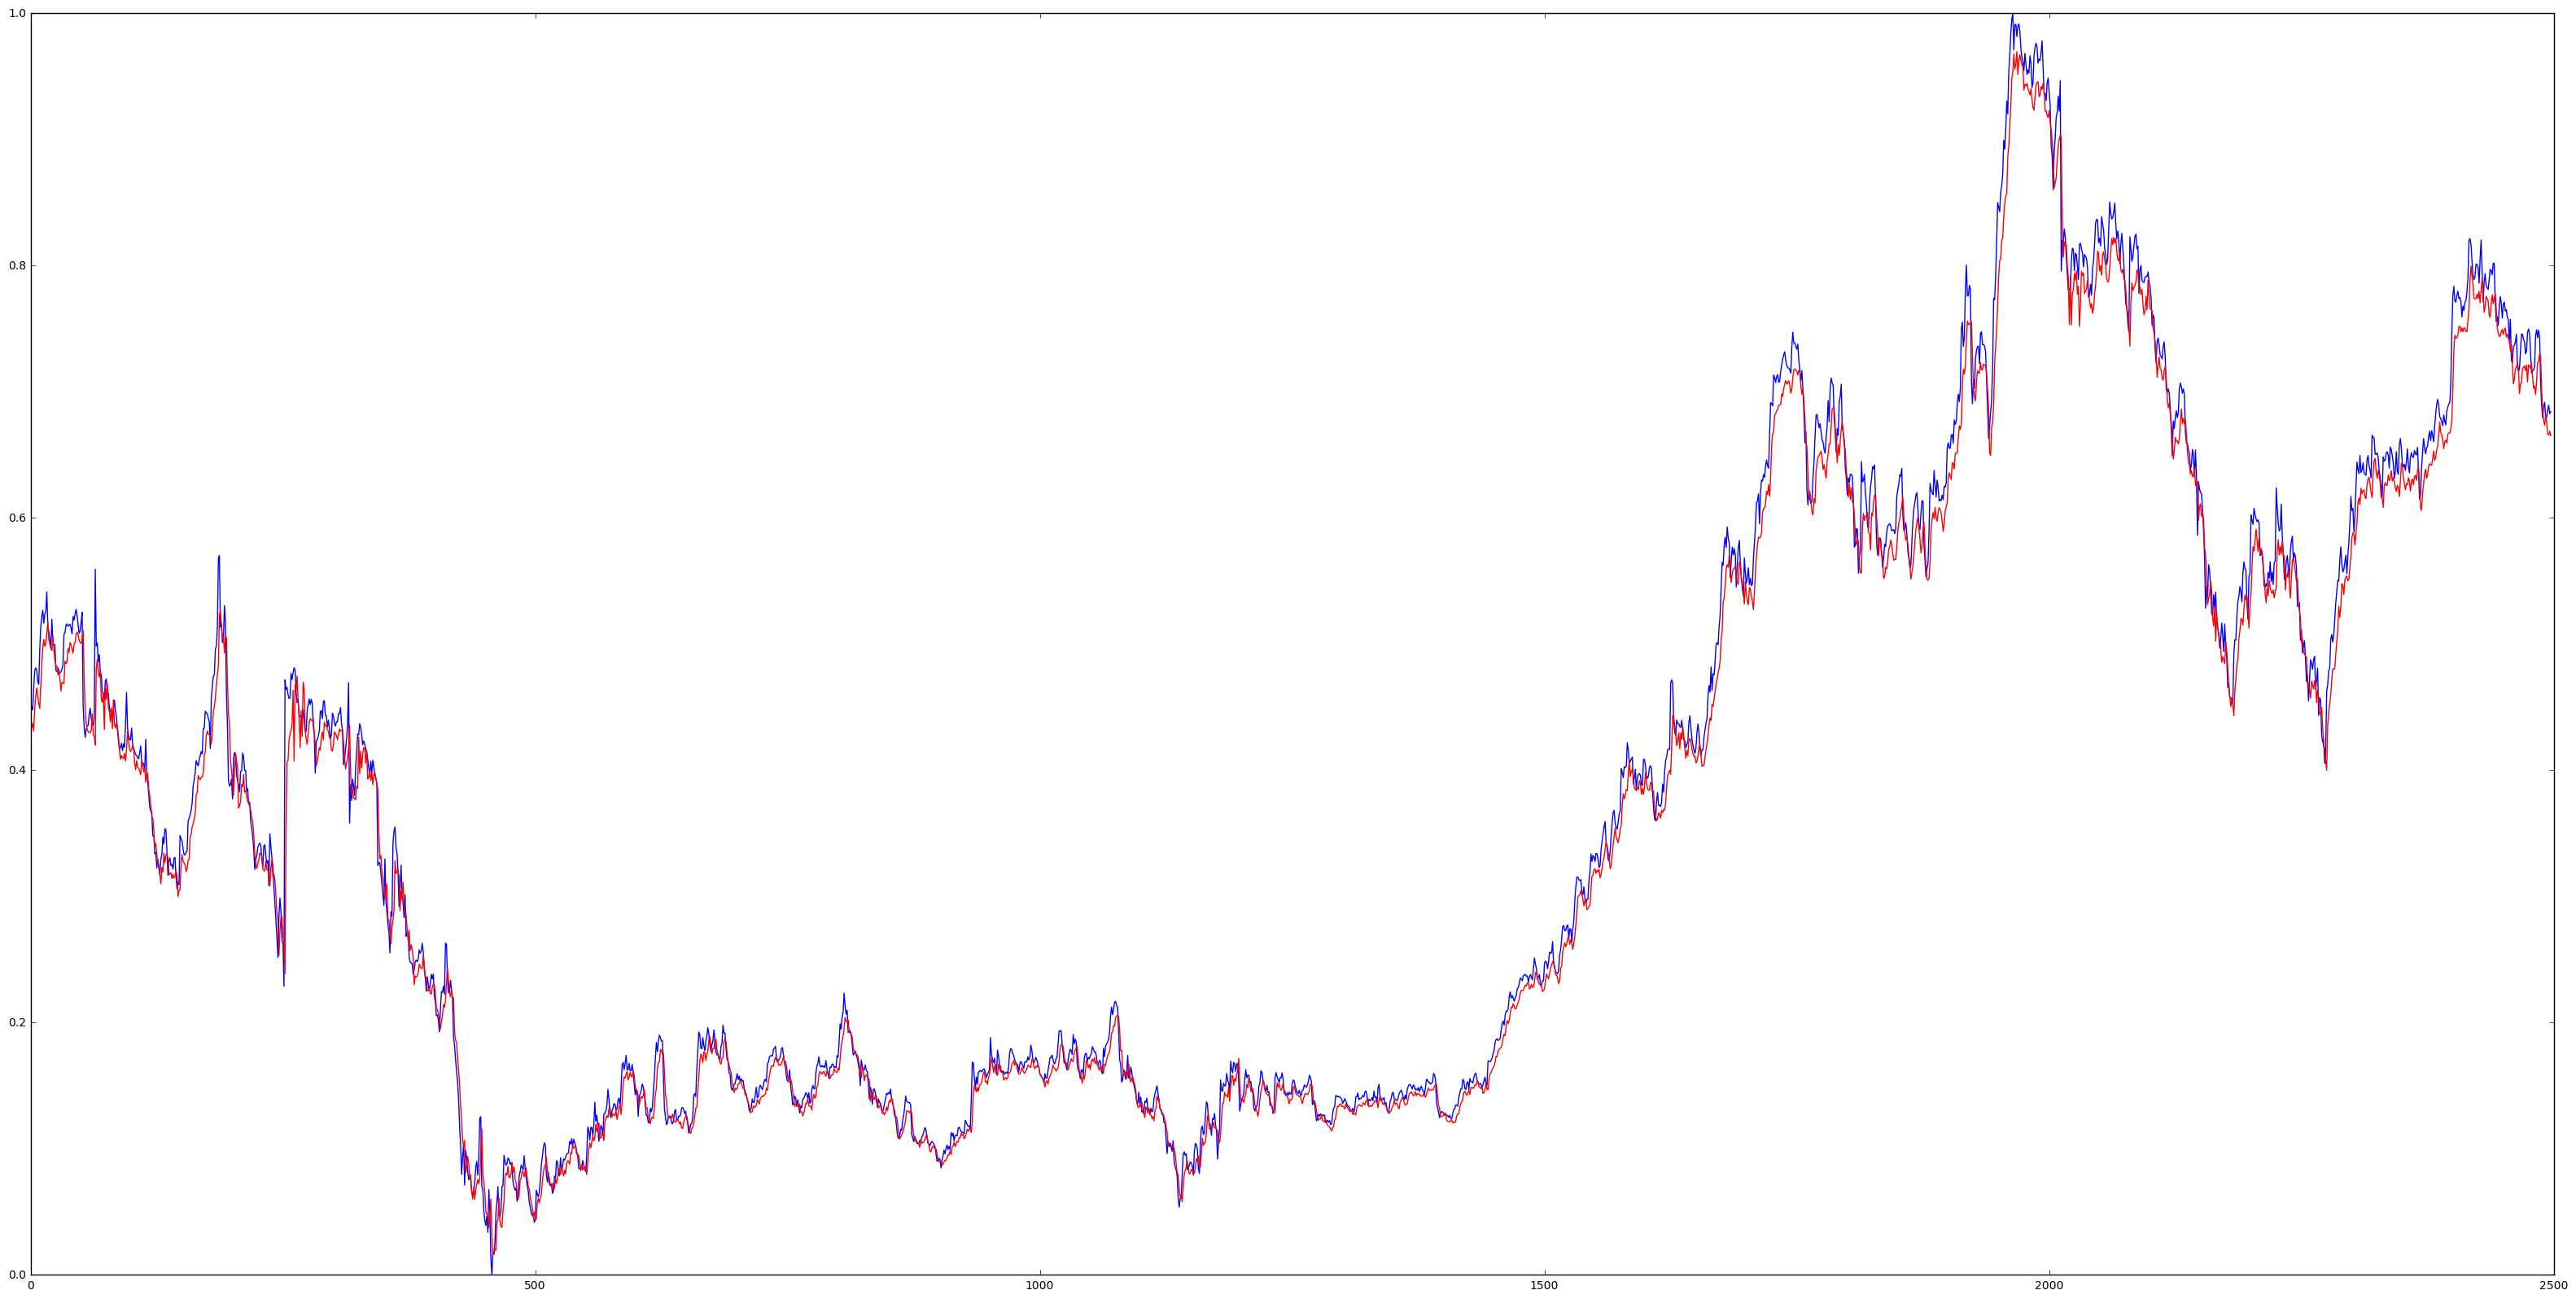

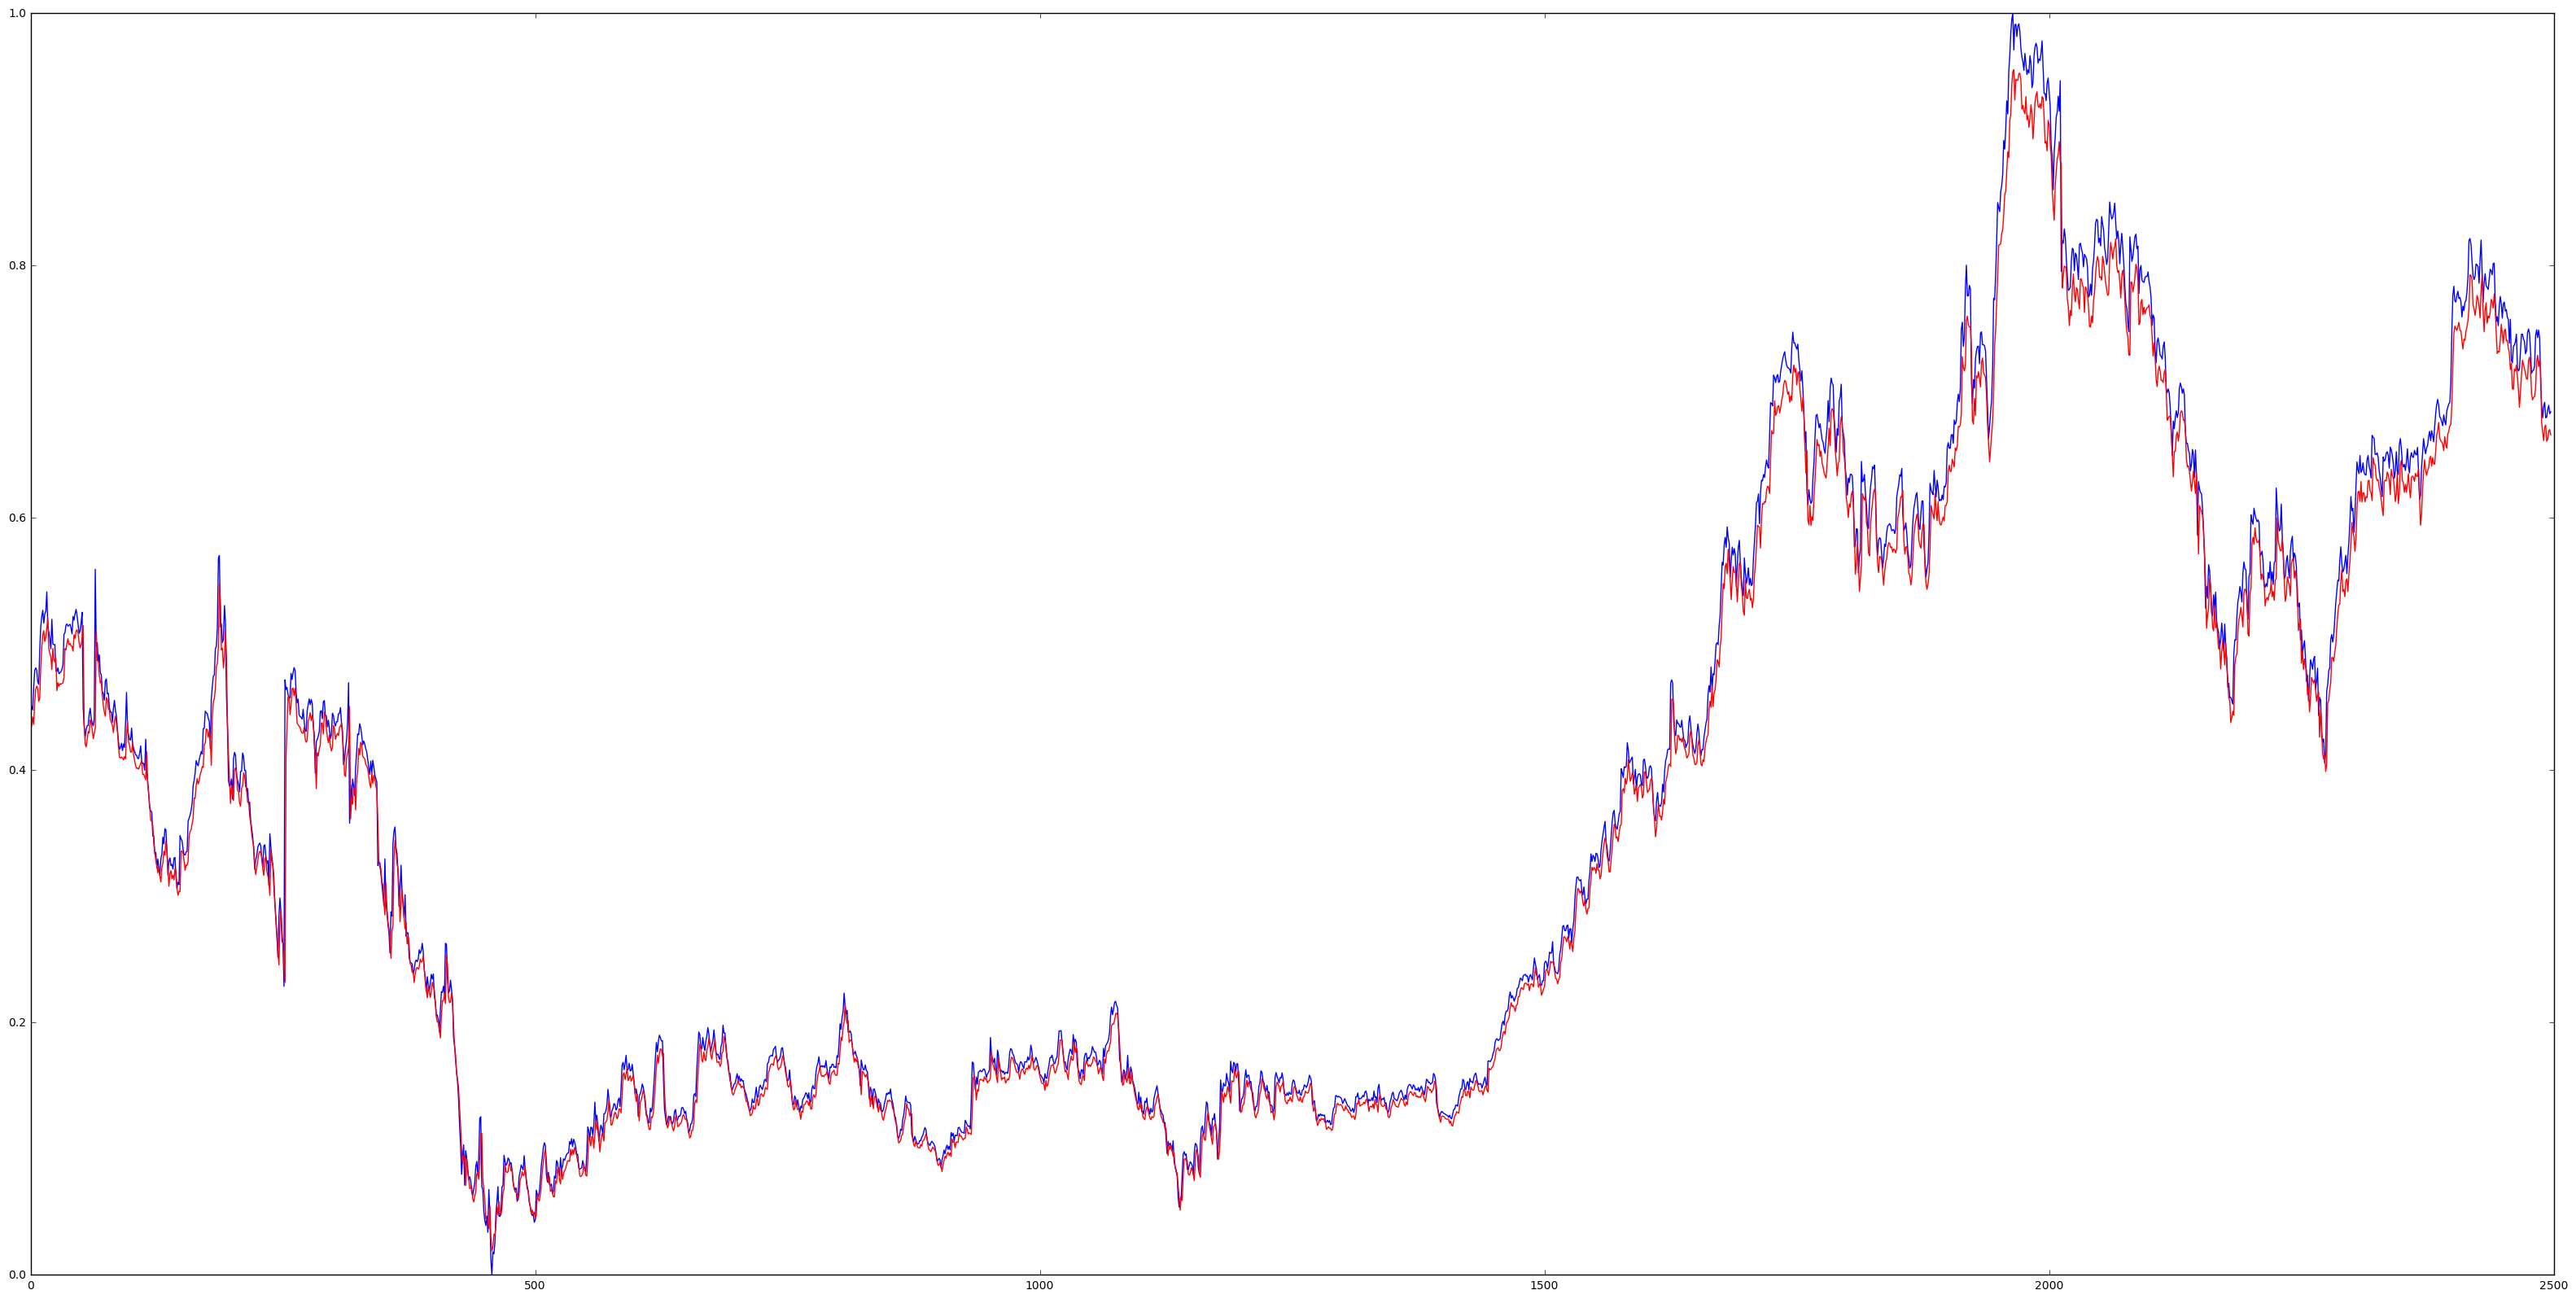

In [23]:
# # Ensemble using NN, Dense Layers

# print(YLen, lenLSTM, lenCONV, lenDENSE, lenCARA2)
# # orderedY = orderedY[-YLen-1 : -1]
# print(lenDENSE, lenLSTM, lenCONV, YLen)
# orderedYHat_LSTM = orderedYHat_LSTM[-YLen:]
# orderedYHat_CONV = orderedYHat_CONV[-YLen:]
# orderedYHat_DENSE = orderedYHat_DENSE[-YLen:]
# orderedYHat_CARA2 = orderedYHat_CARA2[-YLen:]

# orderedY = orderedY[-YLen:]

orderedYHat = []
for i in range(0, YLen):
    temp = [orderedYHat_LSTM[i], orderedYHat_CONV[i], orderedYHat_CARA2[i]]
    orderedYHat.append(temp)

train_size = int(YLen * 0.9)
test_size = YLen - train_size
trainX, trainY = orderedYHat[0:train_size], orderedY[0:train_size]
testX, testY = orderedYHat[train_size:], orderedY[train_size:]

model = Sequential()
model.add(Dense(3, input_dim = len(orderedYHat[0])))
model.add(Dense(2))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse')
history = model.fit(trainX, trainY, batch_size = 1, nb_epoch = 30, initial_epoch = 0)
overallYHat = []
overallYHat = model.predict(orderedYHat, batch_size = 1, verbose = 0);
testYHat = model.predict(testX, batch_size = 2, verbose = 0);
# So far we are using all the data for training. We will want 70% for training and 30 for evaluateY 

def evaluateY(Y, YHat):
    total = len(YHat)
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    return (count * 100.0 / total)

print()
print('LSTM: {}'.format(evaluateY(orderedY, orderedYHat_LSTM)))
print('CONV: {}'.format(evaluateY(orderedY, orderedYHat_CONV)))
print('DENSE: {}'.format(evaluateY(orderedY, orderedYHat_DENSE)))
print('CARA2: {}'.format(evaluateY(orderedY, orderedYHat_CARA2)))

print()
print('Overall on everything: {}'.format(evaluateY(orderedY, overallYHat)))
print('Overall on test: {}'.format(evaluateY(testY, testYHat)))


plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_LSTM, c = 'r')
plt.show()

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_CONV, c = 'r')
plt.show()

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(orderedYHat_DENSE, c = 'r')
plt.show()

plt.figure(figsize=(40,20))
plt.plot(orderedY)
plt.plot(overallYHat, c = 'r')
plt.show()


In [9]:
# Trend Voting
def evaluateY_trend(Y, YHat1, YHat2, YHat3, YHat4):
    total = len(Y)
    count = 0
    for i in range(1, total-1):
        t1 = 1 if YHat1[i] - YHat1[i-1] >= 0 else -1
        t2 = 1 if YHat2[i] - YHat2[i-1] >= 0 else -1
        t3 = 1 if YHat3[i] - YHat3[i-1] >= 0 else -1
        t4 = 1 if YHat4[i] - YHat4[i-1] >= 0 else -1
        if (0.5*t1 + 0.00*t2 + 0.00*t3 + 0.5*t4) * (Y[i] - Y[i-1]) >= 0:
            count += 1
    return (count * 100.0 / total)

print(evaluateY_trend(orderedY, orderedYHat_LSTM, orderedYHat_CONV, orderedYHat_DENSE, orderedYHat_CARA2))

81.9455564452


In [20]:
# Ensemble with manual weights
from copy import deepcopy

def multiply_list(l, weight):
    l2 = []
    l2 = deepcopy([x * weight for x in l])
    return l2
# print(orderedYHat_LSTM)
# print(orderedYHat_CONV[0])
# print(orderedYHat_DENSE[0])

def weight_tweaking(w1, w2):
    man_YHat = []
    for i in range(YLen):
        x = (orderedYHat_LSTM[i]*w1 + orderedYHat_CONV[i]*w2 + orderedYHat_CARA2[i]*(1 - w1 - w2))
        man_YHat.append(x)
    return man_YHat

def grid_search():
    maxVal = 0
    w1, w2 = 0.1, 0.85
    while w1 < 0.9:
        w2 = 0.85 - w1
        while w2 > 0.1 and w1+w2 < 1:
            val = evaluateY(orderedY, weight_tweaking(w1, w2))
            maxVal = max(maxVal, val)
            print('Overall on everything:{}  ,  {} : {}'.format(w1, w2, val))
            w2 -= 0.01
        w1 += 0.01
    print("max val: {}".format(maxVal))
grid_search()  
# print len(man_YHat)
# print (man_YHat[0])

Overall on everything:0.1  ,  0.75 : 56.645316253
Overall on everything:0.1  ,  0.74 : 56.3650920737
Overall on everything:0.1  ,  0.73 : 56.4451561249
Overall on everything:0.1  ,  0.72 : 56.5252201761
Overall on everything:0.1  ,  0.71 : 56.6052842274
Overall on everything:0.1  ,  0.7 : 56.6052842274
Overall on everything:0.1  ,  0.69 : 56.7654123299
Overall on everything:0.1  ,  0.68 : 56.6853482786
Overall on everything:0.1  ,  0.67 : 56.8054443555
Overall on everything:0.1  ,  0.66 : 57.0056044836
Overall on everything:0.1  ,  0.65 : 57.0456365092
Overall on everything:0.1  ,  0.64 : 57.1257005604
Overall on everything:0.1  ,  0.63 : 57.0456365092
Overall on everything:0.1  ,  0.62 : 57.0056044836
Overall on everything:0.1  ,  0.61 : 57.0456365092
Overall on everything:0.1  ,  0.6 : 57.1657325861
Overall on everything:0.1  ,  0.59 : 57.4059247398
Overall on everything:0.1  ,  0.58 : 57.4459567654
Overall on everything:0.1  ,  0.57 : 57.5260208167
Overall on everything:0.1  ,  0.56

In [ ]:
def evaluateY(Y, YHat):
    total = len(YHat)
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    return (count * 100.0 / total)

1248


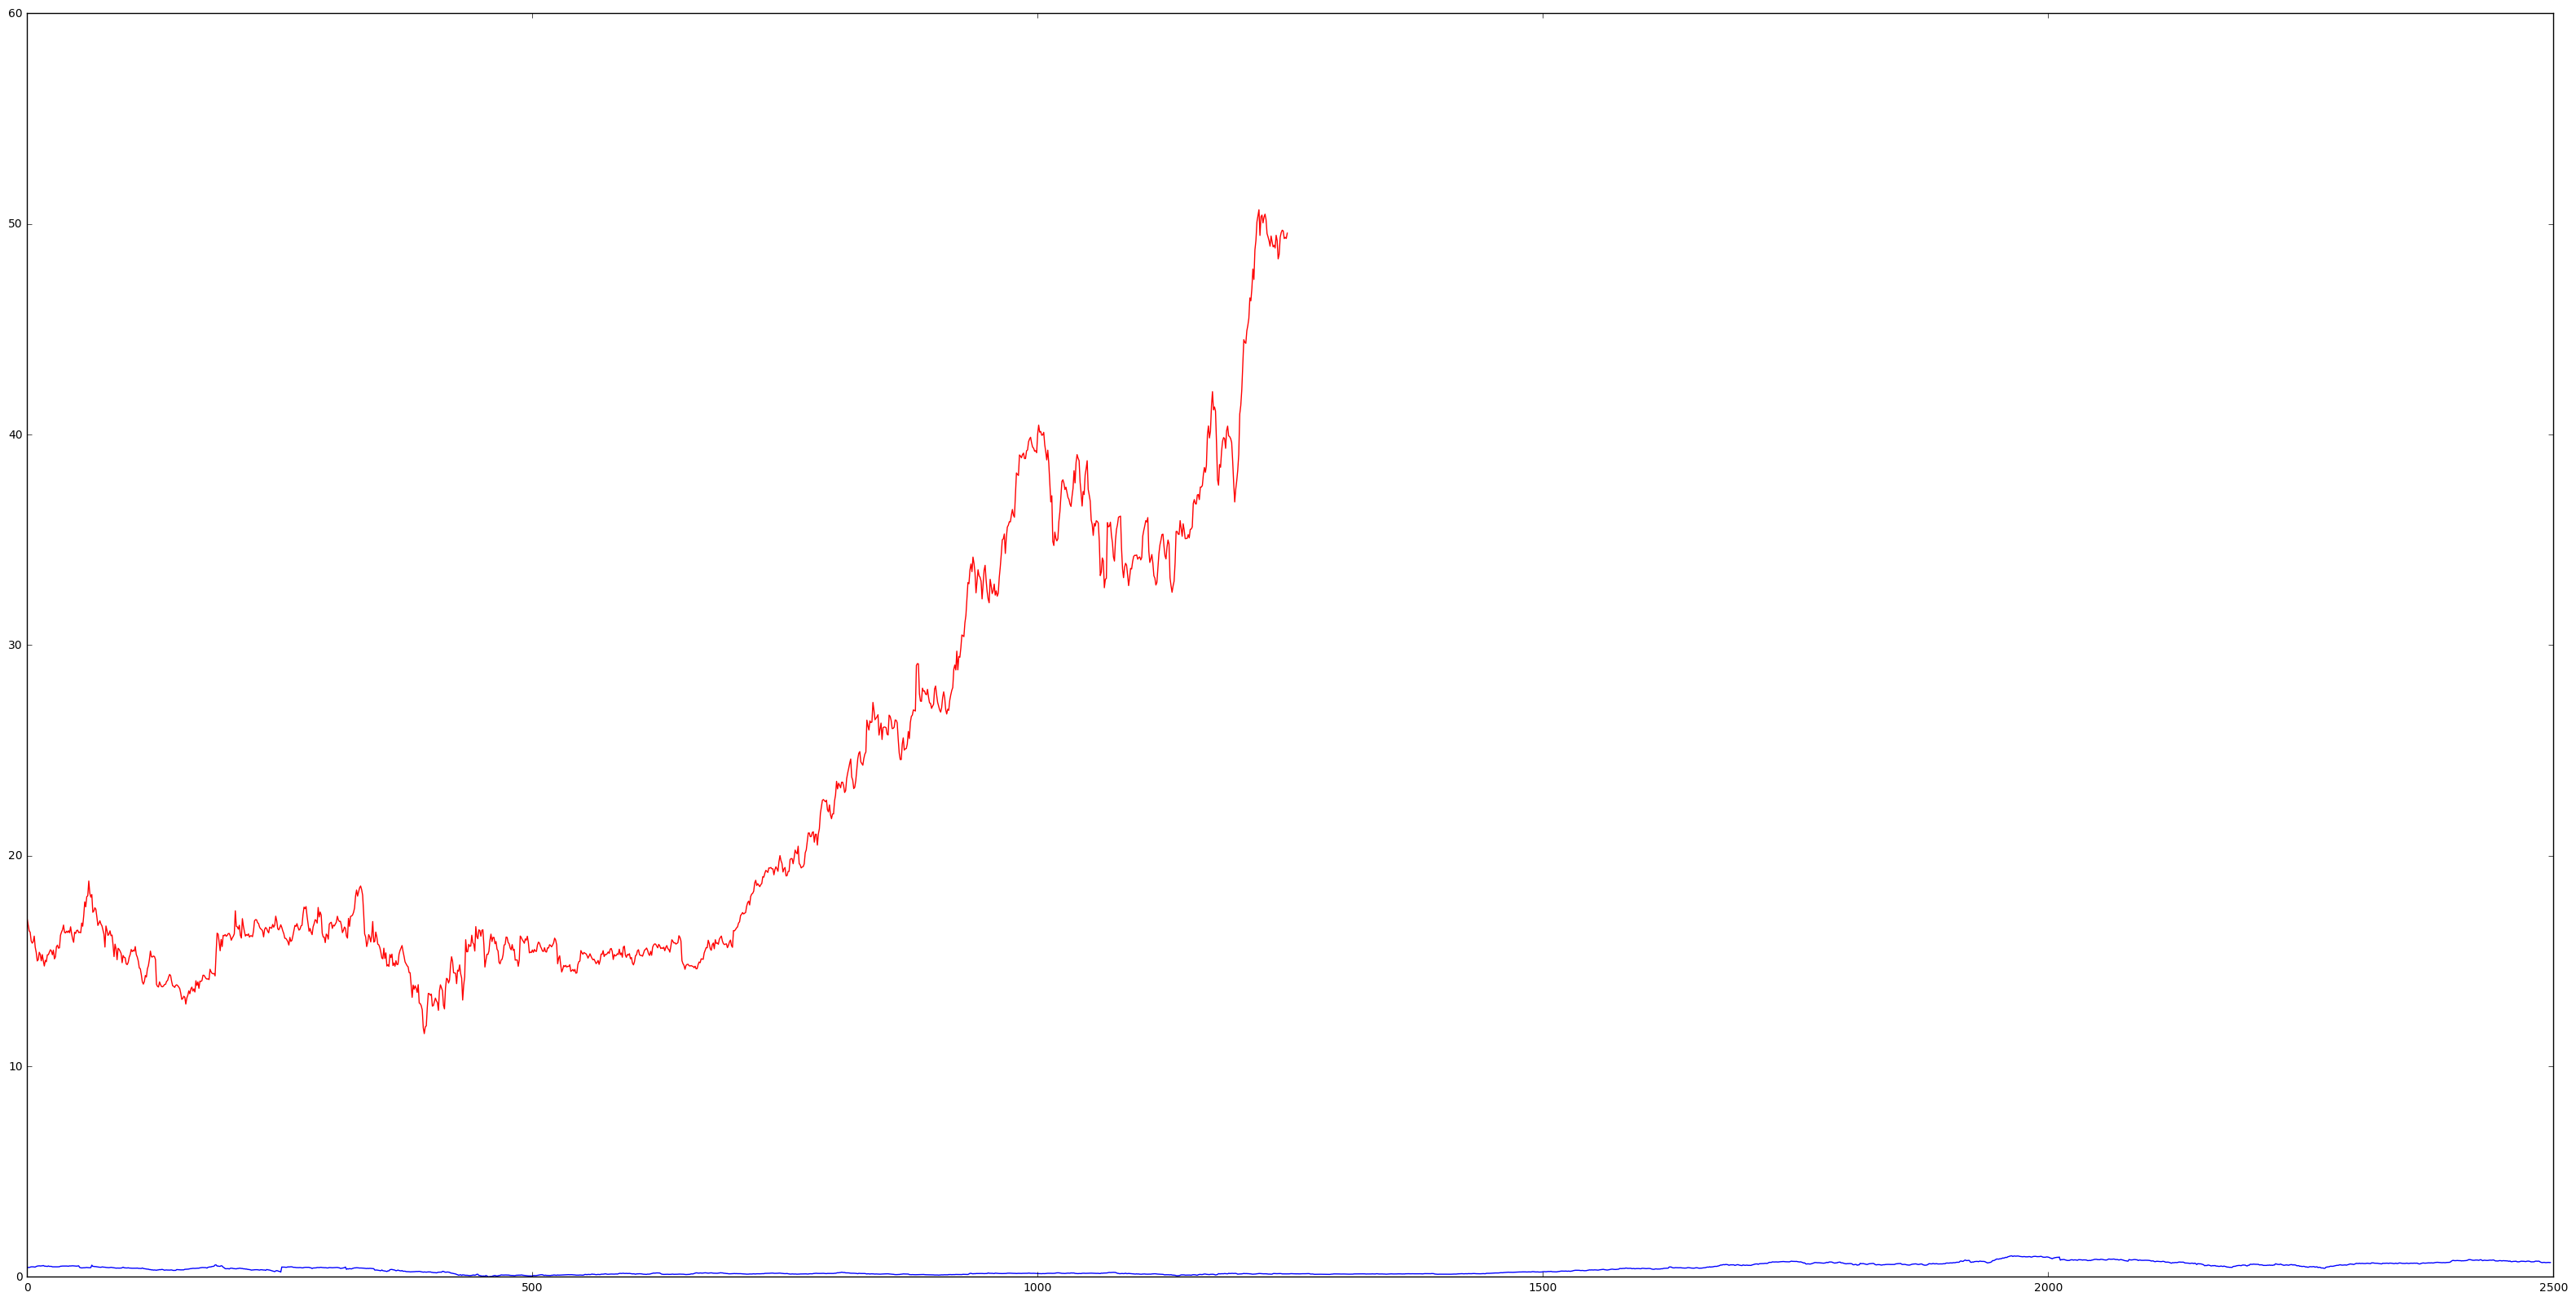

In [11]:
dataframe_gene = pandas.read_csv('orderedYHat_Part3+Nasdaq89+Verified', usecols="0")

geneYHat = dataframe_gene.values

geneYHat = geneYHat.ravel()
def evaluateY(Y, YHat):
    total = len(YHat)
#     print(len(Y))
#     print(total)
    count = 0
    for i in range(1, total-1):
        if (YHat[i] - YHat[i-1]) * (Y[i] - Y[i-1]) > 0:
            count += 1
    return (count * 100.0 / total)

print len(geneYHat)
plt.figure(figsize=(40,20))

plt.plot(orderedY)
plt.plot(geneYHat, c = 'r')
plt.show()
YLen = len(geneYHat)
def weight_tweaking(w1, w2, w3):
    man_YHat = []
    for i in range(YLen):
        x = (orderedYHat_LSTM[i]*w1 + orderedYHat_CONV[i]*w2 + orderedYHat_DENSE[i]*(1 - w1 - w2-w3) + geneYHat[i]*w3)
        man_YHat.append(x)
    return man_YHat

In [12]:
gene_man = weight_tweaking(.8, .1, .1)
print('Overall on everything: {}'.format(evaluateY(orderedY, gene_man)))

Overall on everything: 52.0833333333


In [13]:
x = [[1], [2], [3]]
x = np.array(x)
x = x.ravel()
x = x.ravel()
print(x.shape)
print(x)


(3,)
[1 2 3]


In [14]:
print geneYHat

[ 17.01721382  16.72304535  16.43849564 ...,  49.36474228  49.31121445
  49.5650444 ]
